In [46]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone

In [47]:
start_day_to_analyze = '2020-04-09'
end_day_to_analyze = '2020-04-10'

In [48]:
base_url = "https://api.alpaca.markets"
api_key_id = "AKVKN4TLUUS5MZO5KYLM"
api_secret = "nkK2UmvE1kTFFw1ZlaqDmwCyiuCu7OOeB5y2La/X"

In [49]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [50]:
api = tradeapi.REST(
    base_url=base_url, key_id=api_key_id, secret_key=api_secret
)
session = requests.session()

In [51]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [52]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [53]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,1471,228,AAL,buy,56,13.14,"{'rsi': 74.01898900012652, 'macd': [0.18365765...",2020-04-09T14:04:37.831241613Z,2020-04-09 14:04:38.248057,12.08,16.35
1,1475,228,AAL,sell,56,13.34,"{'rsi': 79.82363352881939, 'reasons': 'rsi max...",2020-04-09T14:06:37.006292903Z,2020-04-09 14:06:37.511916,12.08,16.35
2,1547,228,ADNT,buy,95,12.50,"{'rsi': 63.0377266309325, 'macd': [0.030826354...",2020-04-09T14:42:25.761083906Z,2020-04-09 14:42:29.933815,11.88,14.36
3,1645,228,ADNT,sell,95,12.32,"{'rsi': 45.34060418097216, 'reasons': 'below c...",2020-04-09T15:06:04.748753914Z,2020-04-09 15:06:04.974920,11.88,14.36
4,1443,228,AGNC,buy,78,12.47,"{'rsi': 63.47570209430396, 'macd': [0.21113767...",2020-04-09T13:50:21.127306177Z,2020-04-09 13:50:31.391455,11.71,14.75
...,...,...,...,...,...,...,...,...,...,...,...
215,1524,228,WTTR,buy,268,3.25,"{'rsi': 68.85879961197038, 'macd': [0.00531632...",2020-04-09T14:36:13.831874064Z,2020-04-09 14:36:24.664538,3.03,3.91
216,1535,228,WTTR,sell,89,3.33,"{'rsi': 74.67980326999889, 'reasons': 'scale-o...",2020-04-09T14:38:19.589102962Z,2020-04-09 14:38:30.912681,3.03,3.91
217,1539,228,WTTR,sell,179,3.37,"{'rsi': 78.93013072699506, 'reasons': 'rsi max...",2020-04-09T14:40:08.270874722Z,2020-04-09 14:40:11.366136,3.03,3.91
218,1522,228,X,buy,357,7.13,"{'rsi': 61.37471108315392, 'macd': [0.00786580...",2020-04-09T14:36:08.410127358Z,2020-04-09 14:36:24.534077,6.99,7.65


In [54]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))

In [55]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}

for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' else -1)
            revnue += delta

        revenues[run_id].append(revnue)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [56]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
1,228,momentum_long,PAPER,v0.1-222-g2b83068,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-04-09 13:45:01.010268,None,None


,symbol,count,revenue
97,BMA,1,-2823.66
10,LC,3,-2046.81
94,ECC,1,-1414.59
95,GBDC,1,-1369.50
98,ALDX,1,-1195.56
96,PHR,1,-1180.80
93,NEWT,1,-1108.10
73,EPRT,2,-774.40
4,DLPH,4,-88.82
65,NOVA,2,-83.30


TOTAL REVENUE: -14061.92 $


In [57]:

minute_history = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    for symbol, count in symbols.items():
        if symbol not in minute_history:
            minute_history[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=7)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date()).df

In [61]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.01 <= float(item - prev) / prev <= 0.01:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    minute_history_index = minute_history["high"].index.get_loc(now, method='nearest')
    series = minute_history["high"].dropna().resample("5min").max()
    #print(f'current_value={current_value} series = {series.values}')
    diff = np.diff(series.values)
    high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
    if len(high_index) > 0:
        local_maximas = sorted([series[i] for i in high_index if series[i] >= current_value])
        #print(local_maximas)
        clusters = dict(enumerate(grouper(local_maximas), 1))
        #print(clusters)
        resistances = []
        for key, cluster in clusters.items():
            if len(cluster) > 1:
                resistances.append(round(sum(cluster) / len(cluster), 2))
        resistances = sorted(resistances)
        #print (f'resistances={resistances}')
        return resistances

    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    minute_history_index = minute_history["high"].index.get_loc(now, method='nearest')
    series = minute_history["low"].dropna().resample("5min").min()
    #print(f'current_value={current_value} series = {series.values}')
    diff = np.diff(series.values)
    high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
    if len(high_index) > 0:
        local_maximas = sorted([series[i] for i in high_index if series[i] <= current_value])
        #print(local_maximas)
        clusters = dict(enumerate(grouper(local_maximas), 1))
        #print(clusters)
        supports = []
        for key, cluster in clusters.items():
            if len(cluster) > 1:
                supports.append(round(sum(cluster) / len(cluster), 2))
        supports = sorted(supports)
        #print (f'supports={supports}')
        return supports
    
    return None

FRAN analysis for run 228 with profit 36.72


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-376.39,-376.39,buy,2020-04-09 13:59:32.191498,2.83,"[1.7, 1.73, 1.77, 1.83, 1.9, 2.03, 2.16, 2.28, 2.35, 2.48, 2.76]",[2.95],133,"{'rsi': 73.73906799305219, 'macd': [0.09231137604510398, 0.09222613959611436, 0.09150720916347455, 0.09813360601353205, 0.10393794991584437], 'sell_macd': [0.05635399643378003, 0.05604707981155199, 0.055339780108367265, 0.05943097800058261, 0.06297436625424879], 'slow macd': [0.0478173064799674, 0.049982265289271854, 0.05197412500900489, 0.055374114099397076, 0.0587607108369399], 'macd_signal': [0.08111368365208087, 0.08333617484088757, 0.08497038170540497, 0.08760302656703038, 0.09087001123679318], 'sell_macd_signal': [0.050000526600170556, 0.05120983724244684, 0.052035825815630925, 0.053514856252621264, 0.05540675825294677]}",4.19,2.39
1,-244.83,131.56,sell,2020-04-09 14:51:41.910647,2.99,None,None,44,"{'rsi': 74.03093022682708, 'reasons': 'scale-out', 'movement': 0.02194496667236371, 'sell_macd': [0.020223117639868615, 0.02179002042779432, 0.023024100256985758, 0.025349044276395283, 0.027335376703514047], 'sell_macd_signal': [0.018445626160207104, 0.019114505013724546, 0.019896424062376787, 0.020986948105180488, 0.0222566338248472]}",4.19,2.39
2,24.84,269.67,sell,2020-04-09 14:52:27.767922,3.03,None,None,89,"{'rsi': 79.22054944580519, 'reasons': 'rsi max', 'movement': 0.02003545506238079, 'sell_macd': [0.02179002042779432, 0.023024100256985758, 0.025349044276395283, 0.027350961119098738, 0.03165179293004794], 'sell_macd_signal': [0.019114505013724546, 0.019896424062376787, 0.020986948105180488, 0.022259750707964137, 0.0241381591523809]}",4.19,2.39
3,-720.52,-745.36,buy,2020-04-09 14:53:48.798347,3.08,"[1.7, 1.73, 1.77, 1.83, 1.9, 2.03, 2.16, 2.28, 2.35, 2.48, 2.76]",[],242,"{'rsi': 79.44991683610164, 'macd': [0.03960362605902912, 0.043193977737789435, 0.046312413067441494, 0.056205062820673835, 0.06260522929034984], 'sell_macd': [0.023024100256985758, 0.025349044276395283, 0.027350961119098738, 0.03375049422874943, 0.03783648763589609], 'slow macd': [0.057777529163943075, 0.058448915372251165, 0.05913306731300594, 0.06126729416083698, 0.06299051959075141], 'macd_signal': [0.03497783585855694, 0.036621064234403436, 0.038559334001011046, 0.04208847976494361, 0.04619182967002485], 'sell_macd_signal': [0.019896424062376787, 0.020986948105180488, 0.022259750707964137, 0.024557899412121196, 0.027213617056876173]}",3.80,2.84
4,10.32,730.84,sell,2020-04-09 14:54:06.925672,3.02,None,None,242,"{'rsi': 79.18162579345095, 'reasons': 'rsi max', 'movement': -0.0003570153516601541, 'sell_macd': [0.023024100256985758, 0.025349044276395283, 0.027350961119098738, 0.03375049422874943, 0.03777934477875311], 'sell_macd_signal': [0.019896424062376787, 0.020986948105180488, 0.022259750707964137, 0.024557899412121196, 0.02720218848544758]}",3.80,2.84
5,-797.52,-807.84,buy,2020-04-09 14:55:14.031793,3.06,"[1.7, 1.73, 1.77, 1.83, 1.9, 2.03, 2.16, 2.28, 2.35, 2.48, 2.76]",[],264,"{'rsi': 70.37466151066349, 'macd': [0.046312413067441494, 0.056205062820673835, 0.05773913242425266, 0.05907278658746362, 0.06183764057188901], 'sell_macd': [0.027350961119098738, 0.03375049422874943, 0.03466765646706493, 0.035446384750595694, 0.03715128490983277], 'slow macd': [0.05913306731300594, 0.06126729416083698, 0.06201490983465385, 0.0627618926519724, 0.06382856993787467], 'macd_signal': [0.038559334001011046, 0.04208847976494361, 0.04521861029680542, 0.04798944555493706, 0.05075908455832745], 'sell_macd_signal': [0.022259750707964137, 0.024557899412121196, 0.026579850823109943, 0.028353157608607092, 0.030112783068852227]}",3.72,2.84
6,-521.20,276.32,sell,2020-04-09 14:59:26.690957,3.14,None,None,88,"{'rsi': 75.912904766847, 'reasons': 'scale-out', 'movement': 0.02656862745098044, 'sell_macd': [0.035446384750595694, 0.03715128490983277, 0.03950898263248703, 0.04059408497958783, 0.0438630727178535], 'sell_macd_signal': [0.028353157608607092, 0.030

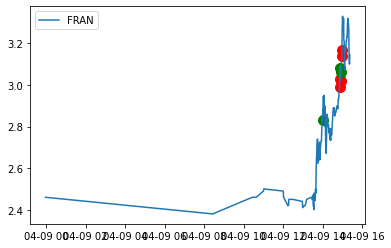

WTTR analysis for run 228 with profit -9.65


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-726.75,-726.75,buy,2020-04-09 13:55:21.200907,3.23,"[2.76, 3.01, 3.09, 3.18]",[3.36],225,"{'rsi': 77.2991231758312, 'macd': [0.05985009486671, 0.060199813762508825, 0.06616953866648245, 0.07886753352097475, 0.08991163167169125], 'sell_macd': [0.03795653793932585, 0.03793930372486187, 0.04158900039248925, 0.04960708869982877, 0.056509403112043444], 'slow macd': [0.017205543792723876, 0.018977460266835777, 0.021856816510684052, 0.026230255715423034, 0.030611848113360818], 'macd_signal': [0.04403491962840443, 0.04726789845522531, 0.05104822649747674, 0.056612087902176346, 0.06327199665607933], 'sell_macd_signal': [0.02838130742460658, 0.030292906684657638, 0.03255212542622396, 0.03596311808094492, 0.04007237508716462]}",4.03,2.97
1,-38.25,688.50,sell,2020-04-09 14:24:07.757241,3.06,None,None,225,"{'rsi': 40.96477491381569, 'reasons': 'below cost & macd negative', 'movement': -0.05718701700154561, 'sell_macd': [0.015201816543464641, 0.011239795184036172, 0.006448092888585055, 0.002111076906563536, -0.0012958326496423922], 'sell_macd_signal': [0.030211988253100775, 0.026417549639287854, 0.022423658289147295, 0.018361142012630543, 0.014429747080175956]}",4.03,2.97
2,-909.25,-871.00,buy,2020-04-09 14:36:24.664538,3.25,"[2.76, 3.01, 3.09, 3.18]",[3.36],268,"{'rsi': 68.85879961197038, 'macd': [0.0053163251169285886, 0.010107190234676544, 0.014543256178955577, 0.021043954497932393, 0.028290439454419225], 'sell_macd': [-0.0002178845857341294, 0.003114554590019747, 0.006190292199828029, 0.010584499529550762, 0.015429537714664932], 'slow macd': [0.04125443615341773, 0.04149423833477428, 0.041808435802172195, 0.04267038487425312, 0.043874968351007126], 'macd_signal': [0.018184904470281434, 0.016569361623160455, 0.016164140534319478, 0.01714010332704206, 0.019370170552517493], 'sell_macd_signal': [0.007564772090098074, 0.006674728590082409, 0.006577841312031533, 0.007379172955535378, 0.008989245907361288]}",3.91,3.03
3,-612.88,296.37,sell,2020-04-09 14:38:30.912681,3.33,None,None,89,"{'rsi': 74.67980326999889, 'reasons': 'scale-out', 'movement': 0.02153846153846149, 'sell_macd': [0.006190292199828029, 0.010584499529550762, 0.015429537714664932, 0.020562950096381982, 0.026373882470493992], 'sell_macd_signal': [0.006577841312031533, 0.007379172955535378, 0.008989245907361288, 0.011303986745165428, 0.01431796589023114]}",3.91,3.03
4,-9.65,603.23,sell,2020-04-09 14:40:11.366136,3.37,None,None,179,"{'rsi': 78.93013072699506, 'reasons': 'rsi max', 'movement': 0.02048192771084339, 'sell_macd': [0.010584499529550762, 0.015429537714664932, 0.020562950096381982, 0.026373882470493992, 0.03409183130135407], 'sell_macd_signal': [0.007379172955535378, 0.008989245907361288, 0.011303986745165428, 0.01431796589023114, 0.018272738972455727]}",3.91,3.03


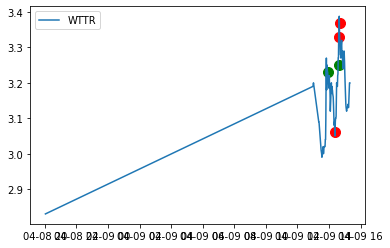

NMRK analysis for run 228 with profit -18.94


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1189.76,-1189.76,buy,2020-04-09 13:49:08.310376,4.16,"[2.8, 2.96, 3.15, 3.36, 3.46, 3.6, 3.75, 3.83]",[4.26],286,"{'rsi': 71.06574985209087, 'macd': [0.07140166039927864, 0.07297721175502447, 0.07759991197100735, 0.0814302336562247, 0.08739609556166528], 'sell_macd': [0.04433997212607199, 0.04514736254227625, 0.047938220495912454, 0.05020202902477333, 0.0538491262027847], 'slow macd': [0.03340912968393717, 0.03544734735711996, 0.038111941310165154, 0.040721610610730874, 0.04383794912258976], 'macd_signal': [0.051770332244507646, 0.05601170814661101, 0.06032934891149028, 0.06454952586043716, 0.06911883980068279], 'sell_macd_signal': [0.03213377408474996, 0.03473649177625522, 0.03737683752018667, 0.039941875821104, 0.04272332589744014]}",4.80,3.96
1,-783.16,406.60,sell,2020-04-09 13:57:07.213428,4.28,None,None,95,"{'rsi': 74.17233256985531, 'reasons': 'scale-out', 'movement': 0.023367285799879987, 'sell_macd': [0.055861810676523405, 0.05514621662129926, 0.055430867790978944, 0.05701071457526208, 0.06061824824385553], 'sell_macd_signal': [0.045351022853256796, 0.04731006160686529, 0.04893422284368802, 0.05054952119000283, 0.05256326660077337]}",4.80,3.96
2,1.85,785.01,sell,2020-04-09 14:20:29.790620,4.11,None,None,191,"{'rsi': 42.23860611518476, 'reasons': 'below cost & macd negative', 'movement': -0.037470725995315986, 'sell_macd': [0.01160736003317453, 0.008353470513462469, 0.0064887063355900665, 0.0036526731276946833, -0.0004228420099856578], 'sell_macd_signal': [0.02494687247574682, 0.02162819208328995, 0.018600294933749973, 0.015610770572538915, 0.012404048056034001]}",4.80,3.96
3,-1254.46,-1256.31,buy,2020-04-09 14:41:16.596756,4.23,"[2.8, 2.96, 3.15, 3.36, 3.46, 3.6, 3.75, 3.83, 4.19]",[4.26],297,"{'rsi': 66.68704620308962, 'macd': [-0.011394037371888821, -0.005868683536890629, -0.0018477518024972994, 0.0036928386082379916, 0.010384835783506574], 'sell_macd': [-0.009074670126388185, -0.005275093849919976, -0.0024900331948805032, 0.0012553391752136989, 0.005715949604180537], 'slow macd': [0.03797168250972849, 0.037710759012317574, 0.03733521802727413, 0.037405005840671635, 0.03788919685837033], 'macd_signal': [-0.009241839401912573, -0.008567208228908184, -0.007223316943626007, -0.0050400858332532075, -0.001955101509901251], 'sell_macd_signal': [-0.008665107546827647, -0.007987104807446114, -0.0068876904849329915, -0.005259084552903653, -0.003064077721486815]}",4.84,4.03
4,-18.94,1235.52,sell,2020-04-09 15:03:15.891262,4.16,None,None,297,"{'rsi': 44.324881760882406, 'reasons': 'below cost & macd negative', 'movement': -0.016528925619834777, 'sell_macd': [0.005820331607179874, 0.004525369359500431, 0.00293805631767885, 0.0014032921770690265, -7.059276596521613e-05], 'sell_macd_signal': [0.008072435621632465, 0.007363022369206058, 0.006478029158900616, 0.0054630817625342986, 0.004356346856834396]}",4.84,4.03


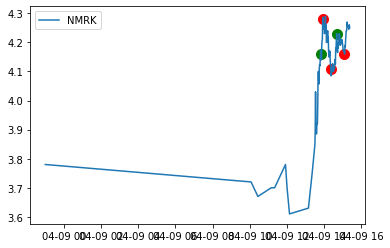

CADE analysis for run 228 with profit -74.2


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1187.26,-1187.26,buy,2020-04-09 13:57:31.323416,6.67,"[4.73, 5.24, 5.81, 5.98, 6.5]",[],178,"{'rsi': 77.19923010826541, 'macd': [0.14535186554215773, 0.14396685323976044, 0.15084564014540636, 0.15770684766241683, 0.16220258748158578], 'sell_macd': [0.08763905754424872, 0.08639492547981753, 0.09055800535844494, 0.09470380779168153, 0.09730178620989527], 'slow macd': [0.08674182899126848, 0.0896468035753033, 0.09410172532802719, 0.09868963738388725, 0.10293674937549024], 'macd_signal': [0.13660988295921656, 0.13808127701532533, 0.14063414964134152, 0.14404868924555658, 0.14767946889276243], 'sell_macd_signal': [0.08347990913704688, 0.08406291240560101, 0.0853619309961698, 0.08723030635527215, 0.08924460232619677]}",7.71,6.37
1,-39.16,1148.10,sell,2020-04-09 14:18:10.101570,6.45,None,None,178,"{'rsi': 45.84510008942558, 'reasons': 'below cost & macd negative', 'movement': -0.03603670819965683, 'sell_macd': [0.010463578817927477, 0.009032419846597861, 0.006760965844956779, 0.0028252748586794496, -0.0002781892197019076], 'sell_macd_signal': [0.02827125728450288, 0.024423489796921875, 0.020890985006528855, 0.017277842976958974, 0.013766636537626798]}",7.71,6.37
2,-1480.18,-1441.02,buy,2020-04-09 14:38:03.763668,6.58,"[4.73, 5.24, 5.81, 5.98, 6.5]",[6.58],219,"{'rsi': 62.446480747147035, 'macd': [-0.0035332120323001703, 0.0017755883223502522, 0.0067123910124911035, 0.010503761883541962, 0.017343112145663753], 'sell_macd': [-0.004162122571734095, -0.0005044511373757388, 0.002871714280791693, 0.0054651975380544116, 0.010012519588674884], 'slow macd': [0.05819509380373855, 0.05760604997334351, 0.05713191400627782, 0.05660431923768794, 0.056828064603751116], 'macd_signal': [-0.009723586059986761, -0.007423751183519359, -0.004596522744317266, -0.0015764658187454204, 0.0022074497741364145], 'sell_macd_signal': [-0.009496084387235553, -0.00769775773726359, -0.005583863333652533, -0.003374051159311144, -0.0006967370097139382]}",7.39,6.31
3,-74.20,1405.98,sell,2020-04-09 14:50:13.270136,6.42,None,None,219,"{'rsi': 39.58768915006418, 'reasons': 'below cost & macd negative', 'movement': -0.02279635258358668, 'sell_macd': [0.011147046550437523, 0.008501959322898323, 0.006590177595946933, 0.0011187869308439957, -0.003159164067040088], 'sell_macd_signal': [0.01156562396069227, 0.01095289103313348, 0.01008034834569617, 0.008288036062725736, 0.005998596036772571]}",7.39,6.31


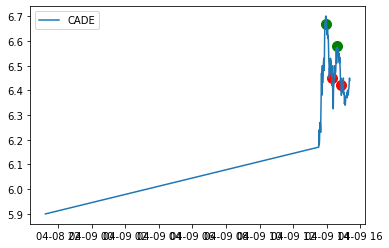

DLPH analysis for run 228 with profit -88.82


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1193.28,-1193.28,buy,2020-04-09 14:00:17.431830,9.04,"[6.58, 6.84, 7.24, 7.66, 7.95, 8.49, 8.7]",[9.04],132,"{'rsi': 78.0652045676161, 'macd': [0.1254909440114158, 0.13099818856203171, 0.1343944834257691, 0.13654491976145167, 0.14066227108129858], 'sell_macd': [0.07392576498127035, 0.07735943669355017, 0.07940438300579977, 0.08063155697630897, 0.08313803595363645], 'slow macd': [0.10329213935804482, 0.10644895585871161, 0.10929823172620523, 0.11194956752956209, 0.11500951371644952], 'macd_signal': [0.11538396034306982, 0.1185068059868622, 0.12168434147464358, 0.1246564571320052, 0.12785761992186387], 'sell_macd_signal': [0.06801371014606543, 0.06988285545556237, 0.07178716096560986, 0.07355604016774968, 0.07547243932492703]}",10.4,8.59
1,-47.52,1145.76,sell,2020-04-09 14:17:37.020545,8.68,None,None,132,"{'rsi': 39.13384609043061, 'reasons': 'below cost & macd negative', 'movement': -0.03318584070796449, 'sell_macd': [0.021810187526623892, 0.015107659326989875, 0.011247148271079865, 0.007053929938278358, -0.0004609665540122876], 'sell_macd_signal': [0.04140874205377709, 0.03614852550841965, 0.03116825006095169, 0.026345386036417024, 0.02098411551833116]}",10.4,8.59
2,-1097.72,-1050.20,buy,2020-04-09 14:44:29.026916,8.90,"[6.58, 6.84, 7.24, 7.66, 7.95, 8.49, 8.7]",[9.04],118,"{'rsi': 62.213638617308675, 'macd': [-0.0040148116696965275, 0.006136970373948003, 0.018807033566274, 0.03011483767916623, 0.03863103933252354], 'sell_macd': [-0.0015667586712648784, 0.005128747979549431, 0.01339630188953933, 0.02070353478187492, 0.026128605415099315], 'slow macd': [0.03941629584239337, 0.04008389755723307, 0.04159362005048095, 0.043235961904446896, 0.04467781906492441], 'macd_signal': [-0.043068146346045826, -0.03322712300204706, -0.02282029168838285, -0.012233265814873034, -0.002060404785393717], 'sell_macd_signal': [-0.028661629361363045, -0.02190355389318055, -0.014843582736636572, -0.007734159232934273, -0.0009616063033275552]}",10.4,8.40
3,-88.82,1008.90,sell,2020-04-09 14:52:15.775447,8.55,None,None,118,"{'rsi': 39.30375757646026, 'reasons': 'below cost & macd negative', 'movement': -0.0314606741573035, 'sell_macd': [0.02620152999553582, 0.016988920603953517, 0.00984936886240817, 0.0031192068707834864, -0.004243506458674773], 'sell_macd_signal': [0.01543701799847049, 0.015747398519567093, 0.014567792588135309, 0.012278075444664945, 0.008973759063997002]}",10.4,8.40


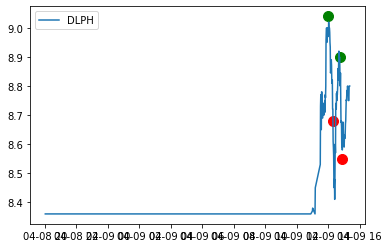

AGNC analysis for run 228 with profit 13.24


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-972.66,-972.66,buy,2020-04-09 13:50:31.391455,12.47,"[9.12, 9.99, 11.18, 12.01]",[12.6],78,"{'rsi': 63.47570209430396, 'macd': [0.2111376771054374, 0.21487119958182, 0.19690434454671468, 0.22070120348449151, 0.23523491115956396], 'sell_macd': [0.13131940871081227, 0.13305350835757324, 0.12066639758417352, 0.13557168272718378, 0.14438655838761782], 'slow macd': [0.0865591168115536, 0.09275808351272019, 0.09461525666159432, 0.1042157742101395, 0.11256200683003748], 'macd_signal': [0.1633945115104088, 0.17368984912469104, 0.17833274820909578, 0.18680643926417492, 0.19649213364325274], 'sell_macd_signal': [0.10244491135365738, 0.10856663075444055, 0.11098658412038714, 0.11590360384174647, 0.12160019475092074]}",14.75,11.71
1,18.72,991.38,sell,2020-04-09 14:04:29.772846,12.71,None,None,78,"{'rsi': 65.37700409792319, 'reasons': 'bail', 'movement': 0.020048115477145148, 'sell_macd': [0.14504139544305694, 0.13618959130888797, 0.12802728170682443, 0.11976019264408855, 0.12033440645696913], 'sell_macd_signal': [0.1480054438218476, 0.14564227331925567, 0.1421192749967694, 0.13764745852623322, 0.1341848481123804]}",14.75,11.71
2,-1688.30,-1707.02,buy,2020-04-09 14:37:21.501592,12.46,"[9.12, 9.99, 11.18, 12.01]",[12.6],137,"{'rsi': 59.6721924198359, 'macd': [-0.023460492162049817, -0.01809810671250922, -0.007308794959023146, 0.0028231022262890093, 0.014717630195109521], 'sell_macd': [-0.01795105418417009, -0.014090597747935973, -0.006743610943752643, 0.00010785424059278625, 0.008042660173321892], 'slow macd': [0.08395052087997179, 0.08200071221579819, 0.08135516540047405, 0.08095099751416157, 0.08124936045040343], 'macd_signal': [-0.02004254447088302, -0.01965365691920826, -0.017184684527171236, -0.013183127176479187, -0.007602975702161444], 'sell_macd_signal': [-0.017757379901993196, -0.017024023471181753, -0.01496794096569593, -0.011952781924438187, -0.00795369350488617]}",13.75,12.03
3,13.24,1701.54,sell,2020-04-09 15:05:06.762820,12.42,None,None,137,"{'rsi': 41.862964016378676, 'reasons': 'below cost & macd negative', 'movement': -0.00396468699839489, 'sell_macd': [0.018349411299952934, 0.015553638263153147, 0.009277014620669988, 0.004005918085997706, -0.0003820262018745524], 'sell_macd_signal': [0.02048215421040672, 0.019496451020956006, 0.0174525637408988, 0.014763234609918583, 0.011734182447559955]}",13.75,12.03


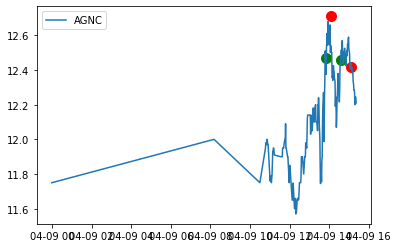

BVN analysis for run 228 with profit -34.03


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1193.20,-1193.20,buy,2020-04-09 13:57:20.380443,7.60,[7.27],[7.7],157,"{'rsi': 73.40103869798928, 'macd': [0.1052364505408292, 0.10191787545950604, 0.102144998966053, 0.10514750314963184, 0.1055039095253747], 'sell_macd': [0.06324064467878276, 0.06082586502949461, 0.06075167484784849, 0.06250228412386605, 0.06253519675292019], 'slow macd': [0.05848169975464668, 0.06026936235357638, 0.06261735683207448, 0.06547711927417588, 0.06784353466888948], 'macd_signal': [0.10536650690553591, 0.10467678061632993, 0.10417042428627454, 0.104365840058946, 0.10459345395223174], 'sell_macd_signal': [0.06465545625644294, 0.06388953801105327, 0.0632619653784123, 0.06311002912750305, 0.06299506265258648]}",8.74,7.22
1,-21.98,1171.22,sell,2020-04-09 14:21:14.761668,7.46,None,None,157,"{'rsi': 47.170544531335715, 'reasons': 'below cost & macd negative', 'movement': -0.018421052631578907, 'sell_macd': [0.009834186040335702, 0.00510344581915767, 0.004208019077730718, 0.0016374525379481142, -0.00038685194159704395], 'sell_macd_signal': [0.022270773496698964, 0.018837307961190704, 0.01591145018449871, 0.01305665065518859, 0.010367950135831463]}",8.74,7.22
2,-1860.81,-1838.83,buy,2020-04-09 14:44:22.446538,7.63,[7.27],[7.73],241,"{'rsi': 67.23603874894903, 'macd': [0.00954220492995983, 0.014924834162235001, 0.019051682316726826, 0.02358352423472798, 0.03205053970626981], 'sell_macd': [0.003366068176015702, 0.007036983106347705, 0.0098579949597708, 0.01291517309283119, 0.018506283675828072], 'slow macd': [0.051242462960336965, 0.0514106321778538, 0.05149912271795554, 0.05180204964394619, 0.053037486132603284], 'macd_signal': [0.011113889694558135, 0.011876078588093508, 0.013311199333820172, 0.015365664314001734, 0.01870263939245535], 'sell_macd_signal': [0.003544658950622733, 0.0042431237817677275, 0.005366098017368342, 0.0068759130324609116, 0.009201987161134344]}",8.40,7.42
3,-34.03,1826.78,sell,2020-04-09 15:20:18.927244,7.58,None,None,241,"{'rsi': 44.81857617265367, 'reasons': 'below cost & macd negative', 'movement': -0.011089367253750811, 'sell_macd': [0.003526425711575243, 0.004208981979680004, 0.0041667013836619304, 0.00200172038178259, -0.00023075468957589607], 'sell_macd_signal': [0.007019059245640967, 0.006457043792448774, 0.005998975310691405, 0.005199524324909642, 0.004113468522012534]}",8.40,7.42


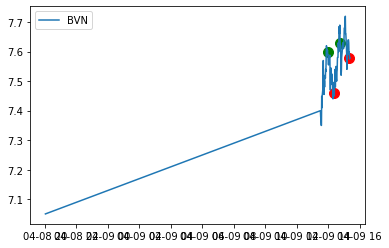

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


LOVE analysis for run 228 with profit -37.02


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-752.10,-752.10,buy,2020-04-09 14:17:14.879816,5.45,"[4.27, 5.03, 5.34]","[5.5, 5.57]",138,"{'rsi': 75.17795895331889, 'macd': [0.1358005973454084, 0.14632534453676005, 0.1501116810024996, 0.15495725309386277, 0.1577854676601005], 'sell_macd': [0.0804588985034771, 0.08713316693387352, 0.0893841141921845, 0.09231492875460567, 0.09391926570253695], 'slow macd': [0.11305664895237211, 0.11731803454318879, 0.12049123570524234, 0.12393768549775075, 0.12707024456635185], 'macd_signal': [0.11901130455650495, 0.12447411255255597, 0.1296016262425447, 0.1346727516128083, 0.13929529482226674], 'sell_macd_signal': [0.07010854595151458, 0.07351347014798637, 0.076687598956826, 0.07981306491638193, 0.08263430507361294]}",6.74,5.02
1,11.04,763.14,sell,2020-04-09 14:49:31.375704,5.53,None,None,138,"{'rsi': 68.84951415487085, 'reasons': 'bail', 'movement': 0.02201834862385323, 'sell_macd': [0.03727833124821078, 0.0401687720412891, 0.04267861198341194, 0.046542401393073085, 0.049862985330561216], 'sell_macd_signal': [0.04604310630351647, 0.044868239451071, 0.044430313957539186, 0.044852731444645966, 0.04585478222182902]}",6.74,5.02
2,-980.42,-991.46,buy,2020-04-09 14:49:48.564086,5.57,"[4.27, 5.03, 5.34]",[5.57],178,"{'rsi': 68.84951415487085, 'macd': [0.0708642950698124, 0.07499200284274554, 0.07856793340167822, 0.08425542391478391, 0.0891552478334301], 'sell_macd': [0.03727833124821078, 0.0401687720412891, 0.04267861198341194, 0.046542401393073085, 0.049862985330561216], 'slow macd': [0.12449539483895222, 0.12491457560831343, 0.12534035595532078, 0.12628971987161108, 0.1272426696884441], 'macd_signal': [0.08503199135390778, 0.08302399365167533, 0.0821327816016759, 0.0825573100642975, 0.08387689761812403], 'sell_macd_signal': [0.04604310630351647, 0.044868239451071, 0.044430313957539186, 0.044852731444645966, 0.04585478222182902]}",6.56,5.24
3,-37.02,943.40,sell,2020-04-09 15:13:54.800148,5.30,None,None,178,"{'rsi': 44.83219955845594, 'reasons': 'below cost & macd negative', 'movement': -0.04308797127468585, 'sell_macd': [0.014635244449335616, 0.007636327687524869, 0.006239297383678455, 0.0014333088692053408, -0.0028497121663484393], 'sell_macd_signal': [0.03138075346990613, 0.02663186831342988, 0.022553354127479594, 0.018329345075824743, 0.014093533627390107]}",6.56,5.24


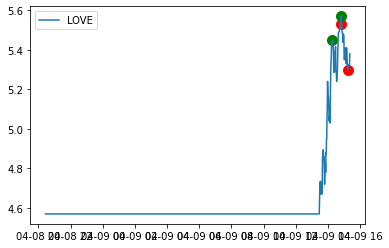

JNUG analysis for run 228 with profit -52.2


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1513.73,-1513.73,buy,2020-04-09 14:34:45.781770,5.89,"[4.86, 5.62, 5.85]",[5.97],257,"{'rsi': 65.13538571660595, 'macd': [-0.010109075310903215, -0.004722130041264094, 0.00019837841832526237, 0.007242100106968685, 0.015869037611096815], 'sell_macd': [-0.008567946482111566, -0.0048252728688327196, -0.0014254587173327948, 0.0033201816438017673, 0.00905288605970167], 'slow macd': [0.057777897978260384, 0.05699581204834736, 0.05631465932026902, 0.05623765369668288, 0.05671660589394012], 'macd_signal': [-0.011182635200954796, -0.009890534169016656, -0.007872751651548273, -0.004849781299844881, -0.0007060175176565415], 'sell_macd_signal': [-0.010590544380016992, -0.009437490077780138, -0.00783508380569067, -0.005604030715792182, -0.002672647360693411]}",6.59,5.67
1,-25.70,1488.03,sell,2020-04-09 14:52:03.322139,5.79,None,None,257,"{'rsi': 42.35273780051317, 'reasons': 'below cost & macd negative', 'movement': -0.01844067796610177, 'sell_macd': [0.017015280537346023, 0.013398838988162964, 0.0067704580538885395, 0.004104570857650813, -3.643956614052257e-05], 'sell_macd_signal': [0.01984064994666522, 0.01855228775496477, 0.016195921814749523, 0.013777651623329782, 0.011014833385435721]}",6.59,5.67
2,-1602.45,-1576.75,buy,2020-04-09 15:00:43.547948,5.95,"[4.86, 5.62, 5.85]",[5.98],265,"{'rsi': 61.65577204390213, 'macd': [0.014825838355497112, 0.020892142346462528, 0.023891188010650488, 0.02676632420896663, 0.029503638048571368], 'sell_macd': [0.008083775371036772, 0.012069379759697796, 0.014031287338398535, 0.015897302499224608, 0.017659167527151354], 'slow macd': [0.044452411884280174, 0.045009578338270906, 0.0451463243187904, 0.04535986578376505, 0.04564212066092299], 'macd_signal': [0.012838947260575615, 0.014449586277752998, 0.016337906624332495, 0.01842359014125932, 0.02063959972272173], 'sell_macd_signal': [0.006621094561727309, 0.007710751601321406, 0.008974858748736832, 0.010359347498834387, 0.01181931150449778]}",6.63,5.75
3,-52.20,1550.25,sell,2020-04-09 15:11:06.124783,5.85,None,None,265,"{'rsi': 46.49350232069739, 'reasons': 'below cost & macd negative', 'movement': -0.0167339486423558, 'sell_macd': [0.005591770623504466, 0.005571343494838565, 0.0036700841284122987, 0.0016162445684901883, -5.140082988575045e-06], 'sell_macd_signal': [0.009893261068155853, 0.009028877553492395, 0.007957118868476377, 0.006688944008479139, 0.005350127190185596]}",6.63,5.75


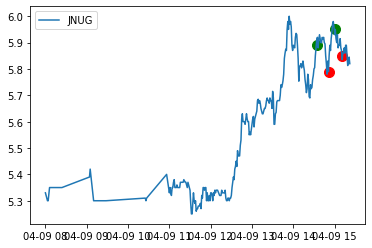

ENDP analysis for run 228 with profit 10.35


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1339.42,-1339.42,buy,2020-04-09 14:30:44.338914,3.86,"[3.2, 3.75]","[3.92, 3.98]",347,"{'rsi': 66.65216322181386, 'macd': [-0.0076104173387201435, -0.0042636162891036555, 0.0015979926960842938, 0.0072650881380851295, 0.013720332850329697], 'sell_macd': [-0.006264012995614632, -0.0039387112532711654, 2.2863544408835423e-06, 0.0037848522000034635, 0.008049385947194843], 'slow macd': [0.031712126783462136, 0.031305625855686525, 0.0315213071278837, 0.03188843922657014, 0.03259584314587061], 'macd_signal': [-0.004237214017222406, -0.004242494471598656, -0.003074397038062066, -0.0010065000028326265, 0.0019388665677998384], 'sell_macd_signal': [-0.004767347294971887, -0.004601620086631742, -0.0036808387984172174, -0.0021877005987330812, -0.00014028328954749638]}",4.37,3.69
1,-885.17,454.25,sell,2020-04-09 14:37:05.827144,3.95,None,None,115,"{'rsi': 72.83898359577734, 'reasons': 'scale-out', 'movement': 0.0210362694300518, 'sell_macd': [0.014705335302596545, 0.016436598577246553, 0.018091653095450688, 0.02122427151099382, 0.024490931685300144], 'sell_macd_signal': [0.006728034810905902, 0.008669747564174032, 0.010554128670429364, 0.012688157238542256, 0.015048712127893833]}",4.37,3.69
2,10.35,895.52,sell,2020-04-09 14:59:33.627169,3.86,None,None,232,"{'rsi': 42.13292231110777, 'reasons': 'below cost & macd negative', 'movement': -0.020577489089617308, 'sell_macd': [0.005637141152741609, 0.0037429138197837553, 0.0027377637704693036, 0.001399494072685581, -0.0006952549654926088], 'sell_macd_signal': [0.01191240693081216, 0.01027850830860648, 0.008770359400979044, 0.007296186335320351, 0.005697898075157759]}",4.37,3.69


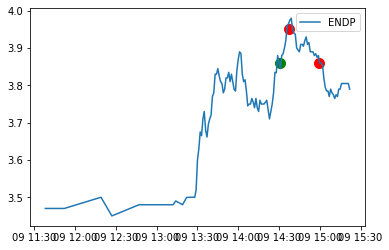

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


LC analysis for run 228 with profit -2046.81


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1190.00,-1190.00,buy,2020-04-09 14:00:30.995563,8.50,"[7.0, 7.53, 8.07]",[8.59],140,"{'rsi': 77.3792375629576, 'macd': [0.06762294658879497, 0.06847215380858529, 0.07633438563253847, 0.08162434634210314, 0.08643415206791971], 'sell_macd': [0.04205552342870078, 0.0423704462146155, 0.047260380252801326, 0.050456947292261134, 0.05333145476077128], 'slow macd': [0.02655714102893114, 0.028511498284949255, 0.03186332957361593, 0.034896160631964435, 0.037950522736215575], 'macd_signal': [0.05744655205544656, 0.05965167240607431, 0.06298821505136715, 0.06671544130951435, 0.07065918346119542], 'sell_macd_signal': [0.03629813933389238, 0.037512600710037, 0.039462156618589865, 0.04166111475332412, 0.04399518275481355]}",9.78,8.07
1,-25.20,1164.80,sell,2020-04-09 14:22:16.841636,8.32,None,None,140,"{'rsi': 46.53264689848677, 'reasons': 'below cost & macd negative', 'movement': -0.014705882352941176, 'sell_macd': [0.009165508578062642, 0.004229179396363136, 0.002405686795086126, 0.0012132810435048214, -0.0007705842310183897], 'sell_macd_signal': [0.016970919557055163, 0.014422571524916758, 0.012019194578950631, 0.009858011871861468, 0.007732292651285496]}",9.78,8.07
2,-2046.81,-2021.61,buy,2020-04-09 14:42:49.003809,8.53,"[7.0, 7.53, 8.08]",[8.59],237,"{'rsi': 67.12249109863457, 'macd': [-0.001410157253660671, 0.0005782597616779128, 0.009309033665299893, 0.018436460129217735, 0.026175196417138835], 'sell_macd': [-0.002760597146629351, -0.0013068327169403204, 0.004518267263556197, 0.010557068972207873, 0.015645004472817803], 'slow macd': [0.032139100387311714, 0.031705169388887455, 0.03269465523257864, 0.03403253140427154, 0.03536892602460284], 'macd_signal': [-0.0018781391032018189, -0.0013868593302258725, 0.0007523192688792804, 0.004289147440946972, 0.008666357236185345], 'sell_macd_signal': [-0.0038650575628718918, -0.0033534125936855773, -0.0017790766222372226, 0.0006881524966517968, 0.0036795228918849983]}",9.29,8.29


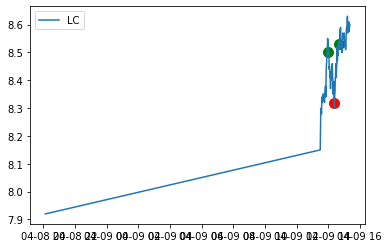

MRO analysis for run 228 with profit 8.37


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1223.60,-1223.60,buy,2020-04-09 14:31:34.793699,4.37,"[3.27, 3.66, 4.13]","[4.41, 4.53]",280,"{'rsi': 61.10639559750726, 'macd': [-0.00847688398092572, -0.004006080550158053, -0.0006570911892982423, 0.004734363052848245, 0.010499925629426698], 'sell_macd': [-0.007501109783985882, -0.004397310345582994, -0.002051527531949482, 0.0016004009920758122, 0.005464236192717742], 'slow macd': [0.0398207486788662, 0.03942097166224379, 0.03895013167747852, 0.03900802718661289, 0.039318777069768274], 'macd_signal': [-0.0022618464096120392, -0.002610693237721242, -0.002219972828036642, -0.0008291056518596647, 0.001436700604397608], 'sell_macd_signal': [-0.004236966986119794, -0.0042690356580124345, -0.003825534032799844, -0.0027403470278247128, -0.001099430383716222]}",5.0,4.16
1,-808.82,414.78,sell,2020-04-09 14:33:28.426489,4.46,None,None,93,"{'rsi': 70.18045241626953, 'reasons': 'scale-out', 'movement': 0.020594965675057177, 'sell_macd': [-0.002051527531949482, 0.0016004009920758122, 0.005495405023887123, 0.009466896412001269, 0.016074981955830125], 'sell_macd_signal': [-0.003825534032799844, -0.0027403470278247128, -0.0010931966174823457, 0.0010188219884143775, 0.004030053981897527]}",5.0,4.16
2,8.37,817.19,sell,2020-04-09 15:03:05.753703,4.37,None,None,187,"{'rsi': 37.48084522701138, 'reasons': 'below cost & macd negative', 'movement': -0.017914798206278094, 'sell_macd': [0.010983304656392967, 0.009356458276724489, 0.006928312288973615, 0.001631986684375697, -0.002573357769653839], 'sell_macd_signal': [0.014798552157845141, 0.01371013338162101, 0.01235376916309153, 0.010209412667348363, 0.007652858579947923]}",5.0,4.16


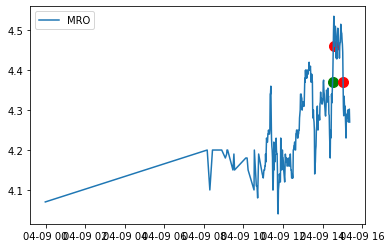

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


MTDR analysis for run 228 with profit 28.7


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-829.5,-829.5,buy,2020-04-09 14:30:23.242666,3.95,"[2.3, 2.35, 2.41, 2.73, 3.03, 3.11, 3.23, 3.29, 3.55, 3.6, 3.7, 3.82]",[4.15],210,"{'rsi': 61.02678563807966, 'macd': [0.006911759027282471, 0.01395192811932322, 0.014921269395203662, 0.016747149091175917, 0.025525292453077775], 'sell_macd': [0.00051655737527323, 0.005345471786991851, 0.006181697669019215, 0.007558215269702906, 0.013441758656343339], 'slow macd': [0.07614327768528417, 0.07591603805221459, 0.07470590508624042, 0.07372096323296118, 0.07420827428560894], 'macd_signal': [0.01685436276835999, 0.016273875838552637, 0.01600335454988284, 0.016152113458141458, 0.018026749257128723], 'sell_macd_signal': [0.006004098018125806, 0.005872372771899015, 0.005934237751323055, 0.006259033254999025, 0.007695578335267888]}",4.82,3.7
1,-545.3,284.2,sell,2020-04-09 14:33:00.263011,4.06,None,None,70,"{'rsi': 66.23246586280635, 'reasons': 'scale-out', 'movement': 0.02010050251256272, 'sell_macd': [0.006181697669019215, 0.007558215269702906, 0.011883317097901802, 0.017696600118603634, 0.025113488185142252], 'sell_macd_signal': [0.005934237751323055, 0.006259033254999025, 0.007383890023579581, 0.009446432042584392, 0.012579843271095964]}",4.82,3.7
2,28.7,574.0,sell,2020-04-09 14:55:54.438942,4.10,None,None,140,"{'rsi': 62.07204112880865, 'reasons': 'bail', 'movement': 0.02214285714285717, 'sell_macd': [0.01879614214345171, 0.016143449515878316, 0.013607020851329032, 0.011973348893870472, 0.01625395062969659], 'sell_macd_signal': [0.026415160887215926, 0.024360818612948403, 0.02221005906062453, 0.020162717027273718, 0.019380963747758294]}",4.82,3.7


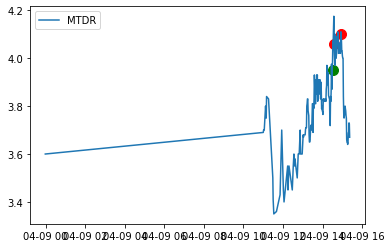

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


MAT analysis for run 228 with profit -15.6


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2892.24,-2892.24,buy,2020-04-09 14:46:06.724758,9.27,"[7.72, 8.36, 9.2]",[9.35],312,"{'rsi': 66.25068904655964, 'macd': [-0.007415742118100255, -0.002316833247832051, 0.0017044410322668568, 0.006431029815454181, 0.013251792767347226], 'sell_macd': [-0.006137944800251205, -0.0026505123819333676, 0.00010138966327488674, 0.0032833732093688894, 0.007798121775033806], 'slow macd': [0.05076544268575667, 0.05016449201563944, 0.04953136708161132, 0.04918952544165833, 0.049436092528704734], 'macd_signal': [-0.010169567942534995, -0.008599021003594406, -0.006538328596422153, -0.003944456914046886, -0.0005052069777680634], 'sell_macd_signal': [-0.00892875973473622, -0.007673110264175649, -0.0061182102786855415, -0.004237893581074655, -0.0018306905098529626]}",9.84,9.08
1,-15.60,2876.64,sell,2020-04-09 15:07:06.867073,9.22,None,None,312,"{'rsi': 44.835860773234046, 'reasons': 'below cost & macd negative', 'movement': -0.004314994606256651, 'sell_macd': [0.010672443103812768, 0.008760705635230792, 0.0053390828592547734, 0.002343804295387386, -0.0002803582776955693], 'sell_macd_signal': [0.017593732004174217, 0.015827126730385534, 0.013729517956159381, 0.011452375224004982, 0.009105828523664872]}",9.84,9.08


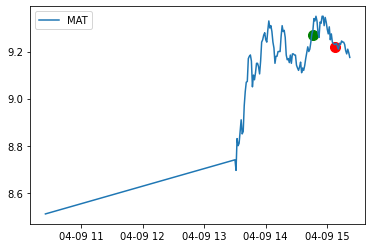

MDRX analysis for run 228 with profit 0.0


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3773.44,-3773.44,buy,2020-04-09 14:28:27.044733,7.04,"[6.15, 6.7]",[7.06],536,"{'rsi': 59.90454777697868, 'macd': [-0.0016560403995642403, -0.0021264998229693077, -0.0008754181766574831, 0.0009124710696166716, 0.005493723657784777], 'sell_macd': [-0.0033105220413505165, -0.003453658300421658, -0.0024813793035880494, -0.00117205308133439, 0.001941344664335709], 'slow macd': [0.03130754482523734, 0.03043290630408979, 0.029899409757756956, 0.02952069196801599, 0.02976478936822957], 'macd_signal': [0.006685759855230636, 0.004923307919590647, 0.0037635627003410207, 0.003193344374196151, 0.0036534202309138762], 'sell_macd_signal': [0.0015049352314551844, 0.0005132165250798159, -8.570264065375715e-05, -0.00030297272878988373, 0.00014589074983523484]}",7.37,6.93
1,0.00,3773.44,sell,2020-04-09 15:04:07.749338,7.04,None,None,536,"{'rsi': 43.57694820559998, 'reasons': 'below cost & macd negative', 'movement': 0.0, 'sell_macd': [0.006481048177285231, 0.005154614089787124, 0.0030151250074528235, 0.0007893526704725318, -0.0009552667177006313], 'sell_macd_signal': [0.009060487240115541, 0.008279312610049858, 0.007226475089530451, 0.005939050605718867, 0.004560187141034967]}",7.37,6.93


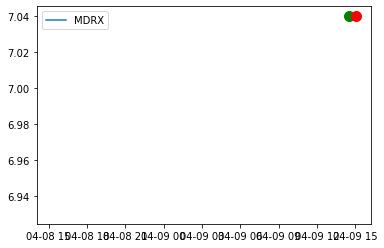

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


PBYI analysis for run 228 with profit -43.5


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1191.9,-1191.9,buy,2020-04-09 13:54:41.142990,8.22,[7.44],[8.26],145,"{'rsi': 71.98289018318124, 'macd': [0.1013775397974328, 0.09902809099914478, 0.10483375828254715, 0.10978311289737697, 0.11480288516942583], 'sell_macd': [0.06146120997201088, 0.05965464014328248, 0.06318647352163254, 0.06615690896552184, 0.06917079490925993], 'slow macd': [0.04603712724755926, 0.04818275315383147, 0.051839032321251644, 0.05543988887260998, 0.059143931803112615], 'macd_signal': [0.09804597409614457, 0.09824239747674461, 0.09956066963790512, 0.10160515828979949, 0.10424470366572476], 'sell_macd_signal': [0.06065242872070557, 0.060452871005220954, 0.06099959150850327, 0.062031054999906986, 0.06345900298177758]}",9.45,7.81
1,-43.5,1148.4,sell,2020-04-09 14:12:34.032941,7.92,None,None,145,"{'rsi': 38.842648579058704, 'reasons': 'below cost & macd negative', 'movement': -0.036496350364963584, 'sell_macd': [0.028172503698586482, 0.01969383842775052, 0.010233919535830083, 0.0016906850806215346, -0.005507818197211023], 'sell_macd_signal': [0.0456882183571726, 0.040489342371288185, 0.03443825780419656, 0.02788874325948156, 0.021209430968143043]}",9.45,7.81


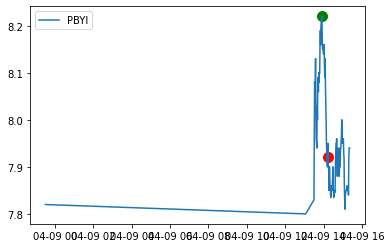

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


CXW analysis for run 228 with profit -11.4


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2551.32,-2551.32,buy,2020-04-09 14:34:35.299982,11.19,"[8.83, 9.71, 10.32, 11.14]",[11.28],228,"{'rsi': 62.481295743442274, 'macd': [0.0009391513786187744, 0.009503059764419675, 0.015306656821506337, 0.01967919973721166, 0.027579292337980732], 'sell_macd': [-0.004168687753859146, 0.001750369341332103, 0.005820409034450691, 0.008916278807863165, 0.01427258929613373], 'slow macd': [0.07969674048922748, 0.0795278942849933, 0.07908542059723445, 0.07855184457247688, 0.07887732805458114], 'macd_signal': [0.0122569131068205, 0.011706142438340335, 0.012426245314973536, 0.01387683619942116, 0.016617327427133073], 'sell_macd_signal': [0.0017621993937462386, 0.0017598333832634116, 0.002571948513500868, 0.0038408145723733272, 0.005927169517125408]}",11.98,10.94
1,-11.40,2539.92,sell,2020-04-09 15:03:15.761350,11.14,None,None,228,"{'rsi': 45.77547850014985, 'reasons': 'below cost & macd negative', 'movement': -0.004366500281277601, 'sell_macd': [0.012796748054453744, 0.01085323307336239, 0.0060809716196121855, 0.002859976050201496, -0.00026365654999338517], 'sell_macd_signal': [0.021458078515532535, 0.019337109427098507, 0.016685881865601243, 0.013920700702521294, 0.011083829252018357]}",11.98,10.94


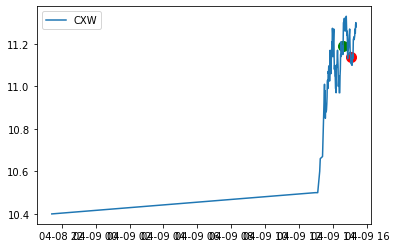

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


MUR analysis for run 228 with profit -20.24


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-791.12,-791.12,buy,2020-04-09 14:37:44.031200,8.99,"[5.61, 5.75, 6.09, 6.77, 7.63, 7.81, 8.36, 8.9]",[9.16],88,"{'rsi': 63.53342469727904, 'macd': [0.06440158642267058, 0.07986331076010522, 0.10303288611553008, 0.11362975699382005, 0.11664861871334864], 'sell_macd': [0.038030328945268366, 0.04816966891406693, 0.0632370809817786, 0.07000081660620694, 0.07176475583814934], 'slow macd': [0.14132476050265197, 0.1429254970131506, 0.14656867683026498, 0.1484066144759506, 0.14906054013161452], 'macd_signal': [0.019120487538351744, 0.03126905218270244, 0.045621818969267966, 0.059223406574178385, 0.07070844900201244], 'sell_macd_signal': [0.006677814842945858, 0.014976185657170073, 0.024628364722091782, 0.03370285509891481, 0.041315235246761714]}",11.0,8.32
1,-20.24,770.88,sell,2020-04-09 15:03:18.933708,8.76,None,None,88,"{'rsi': 40.650994355945954, 'reasons': 'below cost & macd negative', 'movement': -0.022246941045606348, 'sell_macd': [0.02368059346943241, 0.020235997174289366, 0.016250129968019777, 0.008777374612900957, -0.00027642663281390867], 'sell_macd_signal': [0.03068791160213987, 0.02859752871656977, 0.02612804896685977, 0.02265791409606801, 0.018071045950291624]}",11.0,8.32


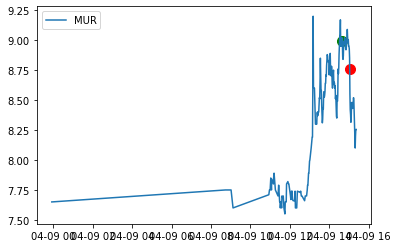

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


PNNT analysis for run 228 with profit -18.32


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-835.85,-835.85,buy,2020-04-09 14:48:28.660433,3.65,"[2.21, 2.31, 2.46, 2.61, 2.74, 2.9, 2.94, 3.05, 3.18, 3.29, 3.6]",[3.67],229,"{'rsi': 66.75444774060607, 'macd': [0.016532295789951856, 0.020821143157737865, 0.024933247013892323, 0.02847710904348455, 0.03252455525990605], 'sell_macd': [0.010748323199110121, 0.013517883594317492, 0.016144581517929968, 0.01837649442570699, 0.02091595260805601], 'slow macd': [0.023175471262181002, 0.023958282581951096, 0.0248384967828561, 0.025730147678157955, 0.026829215298860287], 'macd_signal': [-0.005652032795176046, -0.0003573976045932641, 0.004700731319103853, 0.009456006863979993, 0.014069716543165203], 'sell_macd_signal': [-0.004289925017756522, -0.0007283632953417191, 0.0026462256673126187, 0.005792279418991493, 0.008817014056804396]}",4.43,3.39
1,-18.32,817.53,sell,2020-04-09 15:10:22.918670,3.57,None,None,229,"{'rsi': 44.84015133644402, 'reasons': 'below cost & macd negative', 'movement': -0.021917808219178103, 'sell_macd': [0.00910875284575452, 0.0055500361776785745, 0.0028296071353119956, 0.0010678493472950912, -0.0003188171024230968], 'sell_macd_signal': [0.014581619009054924, 0.012775302442779654, 0.010786163381286122, 0.008842500574487915, 0.0070102370391057125]}",4.43,3.39


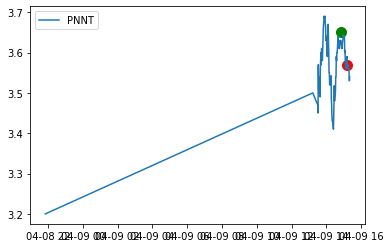

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


FNKO analysis for run 228 with profit -12.24


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-602.82,-602.82,buy,2020-04-09 13:49:35.863080,3.94,"[3.17, 3.3, 3.61]","[3.96, 4.07, 4.21]",153,"{'rsi': 76.0738593978452, 'macd': [0.07756061399940473, 0.08429421429490613, 0.09180009242619747, 0.09823005287178255, 0.10374378196308953], 'sell_macd': [0.04851092577807936, 0.05261845300987922, 0.057213689125438894, 0.06109031870736281, 0.06435664930746743], 'slow macd': [0.02554684323666967, 0.02906134484018752, 0.0328880632769466, 0.03667603883467363, 0.0404223113668567], 'macd_signal': [0.059882876164057686, 0.06476514379022738, 0.0701721335174214, 0.07578371738829362, 0.0813757303032528], 'sell_macd_signal': [0.03791450892740013, 0.040855297743895944, 0.04412697602020453, 0.04751964455763619, 0.05088704550760244]}",5.11,3.55
1,-12.24,590.58,sell,2020-04-09 14:52:35.828465,3.86,None,None,153,"{'rsi': 43.2711404250903, 'reasons': 'below cost & macd negative', 'movement': -0.017766497461928894, 'sell_macd': [0.006254887972435785, 0.0047537560889483466, 0.003262565581179544, 0.0007595266714743865, -0.001200757240912509], 'sell_macd_signal': [0.005789784170193558, 0.005582578553944516, 0.005118575959391521, 0.004246766101808094, 0.003157261433263973]}",5.11,3.55


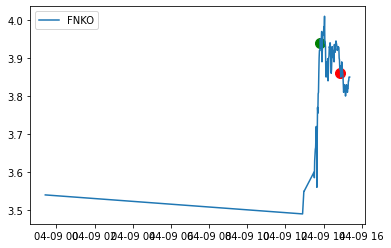

IMO analysis for run 228 with profit -29.75


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1624.35,-1624.35,buy,2020-04-09 14:38:24.806690,13.65,"[12.36, 13.51]",[13.72],119,"{'rsi': 70.28454892509356, 'macd': [0.04151454587359105, 0.06364880824486718, 0.07627652026515541, 0.08849166193045122, 0.09785119842684686], 'sell_macd': [0.025930273078261123, 0.0402752187756672, 0.048332641153182365, 0.05606137753626861, 0.06187518020443861], 'slow macd': [0.0547724290669116, 0.05919615040273207, 0.06237175943596185, 0.06583341051461744, 0.06907288492082664], 'macd_signal': [0.012748433785319974, 0.02292850867722942, 0.03359811099481462, 0.044576821181941936, 0.05523169663092292], 'sell_macd_signal': [0.006557120317466658, 0.013300740009106766, 0.02030712023792189, 0.027457971697591232, 0.034341413398960706]}",15.18,13.21
1,-29.75,1594.60,sell,2020-04-09 15:02:08.877011,13.40,None,None,119,"{'rsi': 41.74866868288365, 'reasons': 'below cost & macd negative', 'movement': -0.02116788321167877, 'sell_macd': [0.012694360674345262, 0.009872134067444804, 0.00572660510015055, 0.000603769474984972, -0.003915372174169818], 'sell_macd_signal': [0.01652301392870275, 0.01519283795645116, 0.013299591385191038, 0.010760427003149825, 0.007825267167685897]}",15.18,13.21


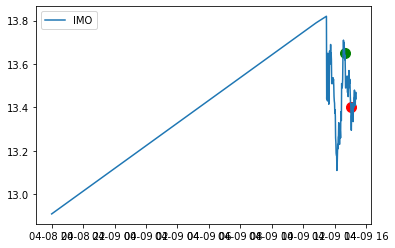

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


EZPW analysis for run 228 with profit -27.92


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1713.59,-1713.59,buy,2020-04-09 14:46:54.336006,4.91,"[4.22, 4.54, 4.84]",[4.91],349,"{'rsi': 60.11461382846451, 'macd': [-0.005765905518130943, 0.00042989107048096997, 0.004481527815741515, 0.007604815547034072, 0.011560612880131771], 'sell_macd': [-0.00540998830431505, -0.00122204064382192, 0.001537685333754979, 0.0036681512210385847, 0.00631957722124632], 'slow macd': [0.023736199262565982, 0.024212204736748788, 0.024451484935528178, 0.02463252363910584, 0.025079560809188273], 'macd_signal': [-0.00168875653442741, -0.0012650270134457338, -0.00011571604760828393, 0.0014283902713201873, 0.0034548347930825046], 'sell_macd_signal': [-0.0033416100458629186, -0.002917696165454719, -0.0020266198656127793, -0.0008876656482825064, 0.0005537829256232591]}",5.42,4.74
1,-27.92,1685.67,sell,2020-04-09 14:55:40.989075,4.83,None,None,349,"{'rsi': 45.593132179864384, 'reasons': 'below cost & macd negative', 'movement': -0.01629327902240327, 'sell_macd': [0.004676145853521163, 0.0030531420990707048, 0.0022682931722384225, 0.000588303188053807, -0.0007284202176487398], 'sell_macd_signal': [0.003867143351863179, 0.0037043431013046844, 0.003417133115491432, 0.002851367130003907, 0.002135409660473378]}",5.42,4.74


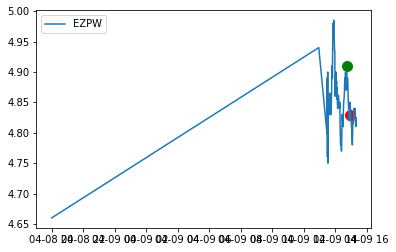

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


GEO analysis for run 228 with profit -22.49


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2366.64,-2366.64,buy,2020-04-09 14:30:49.572054,13.68,"[10.5, 11.14, 11.87, 12.46, 13.55]",[13.94],173,"{'rsi': 61.39629417595368, 'macd': [0.024319983487384178, 0.03494099259276595, 0.039673224882250224, 0.044524139355409886, 0.05340136135739648], 'sell_macd': [0.00841383268936724, 0.015740462166746738, 0.019167180432667408, 0.022627387127768017, 0.02866615355086033], 'slow macd': [0.1215597767226928, 0.12163430810232256, 0.1208685981751394, 0.12029068016828148, 0.12068614116210341], 'macd_signal': [0.034848127774652106, 0.03486670073827487, 0.03582800556706994, 0.03756723232473793, 0.04073405813126964], 'sell_macd_signal': [0.013417179020975238, 0.013881835650129539, 0.014938904606637113, 0.016476601110863295, 0.0189145115988627]}",14.7,13.34
1,-22.49,2344.15,sell,2020-04-09 14:55:11.873501,13.55,None,None,173,"{'rsi': 39.77483810829918, 'reasons': 'below cost & macd negative', 'movement': -0.008771929824561346, 'sell_macd': [0.04563432325762662, 0.03014487318151282, 0.018203160483484027, 0.008142044608609567, -0.0013619683407544159], 'sell_macd_signal': [0.05656490374553025, 0.051280897632726766, 0.04466535020287822, 0.03736068908402449, 0.02961615759906871]}",14.7,13.34


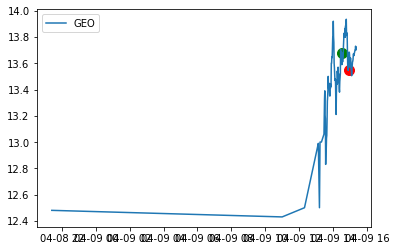

CLF analysis for run 228 with profit -21.1


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1983.4,-1983.4,buy,2020-04-09 14:36:18.737816,4.70,"[3.63, 4.04, 4.5]",[4.76],422,"{'rsi': 60.71465019647484, 'macd': [0.002578678837165782, 0.004509460936716003, 0.007167373283238909, 0.009965824571446014, 0.012044772736605758], 'sell_macd': [0.0011726045798363671, 0.00248769319515052, 0.004259350646107052, 0.006104027222877839, 0.0074621644616224], 'slow macd': [0.024540293168976213, 0.02435325318881887, 0.02438212483732105, 0.024529627901636708, 0.02462610372706031], 'macd_signal': [-0.006188379445167906, -0.004048811368791124, -0.0018055744383851172, 0.0005487053635811093, 0.002847918838186039], 'sell_macd_signal': [-0.005131006056491816, -0.003607266206163349, -0.0020339428357092687, -0.00040634882399184693, 0.0011673538331310029]}",5.12,4.56
1,-21.1,1962.3,sell,2020-04-09 14:52:06.666275,4.65,None,None,422,"{'rsi': 37.71945614407879, 'reasons': 'below cost & macd negative', 'movement': -0.010617021276595756, 'sell_macd': [0.011450894684593038, 0.00860195174016809, 0.0060105422803546915, 0.002406709684651176, -0.0004794807754384678], 'sell_macd_signal': [0.011884090243914921, 0.011227662543165555, 0.010184238490603383, 0.008628732729412942, 0.00680709002844266]}",5.12,4.56


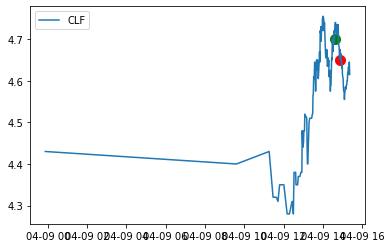

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


ALLY analysis for run 228 with profit -14.22


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1361.96,-1361.96,buy,2020-04-09 14:38:30.844771,17.24,"[12.61, 13.8, 14.64, 15.13, 17.15]",[17.33],79,"{'rsi': 65.3004077015461, 'macd': [-0.030788120291653343, -0.012888985211450432, 0.0020791574891241282, 0.019366686300237745, 0.04226299307475401], 'sell_macd': [-0.025704029549608265, -0.013355858130079667, -0.003040973152135251, 0.00867245635213365, 0.023920940948290337], 'slow macd': [0.15441186694513576, 0.15290818534693784, 0.15144013092916708, 0.15096681875843387, 0.15220913839862504], 'macd_signal': [-0.039026789009405316, -0.033799228249814336, -0.026623551102026643, -0.017425503621573767, -0.0054878042823082104], 'sell_macd_signal': [-0.0349531904887941, -0.030633724017051212, -0.02511517384406802, -0.01835764780482769, -0.009901930054204084]}",19.53,16.53
1,-14.22,1347.74,sell,2020-04-09 15:04:55.031306,17.06,None,None,79,"{'rsi': 41.823301047538905, 'reasons': 'below cost & macd negative', 'movement': -0.012152777777777827, 'sell_macd': [0.012483065533206883, 0.012444733821858733, 0.009915582698447167, 0.004439418411394058, -0.0017035591942509143], 'sell_macd_signal': [0.018829193281174876, 0.017552301389311648, 0.016024957651138753, 0.013707849803189814, 0.01062556800370167]}",19.53,16.53


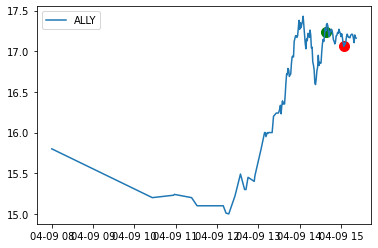

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


EGHT analysis for run 228 with profit 0.7


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1186.5,-1186.5,buy,2020-04-09 13:55:54.572376,16.95,"[12.96, 15.89]",[17.06],70,"{'rsi': 79.37369126299807, 'macd': [0.13671975777957357, 0.14232223077401684, 0.14508972692892996, 0.1511885945496907, 0.17658014502692865], 'sell_macd': [0.08561670919295139, 0.08876287940606886, 0.09006167594348824, 0.09354045667467759, 0.10958183832658008], 'slow macd': [0.04699631856550468, 0.05186442645871736, 0.056260291535267015, 0.0613341997219905, 0.07038247078907034], 'macd_signal': [0.10763161055007463, 0.11456973459486307, 0.12067373306167645, 0.1267767053592793, 0.13673739329280915], 'sell_macd_signal': [0.06836045837580776, 0.07244094258185999, 0.07596508925418563, 0.07948016273828402, 0.08550049785594324]}",19.49,16.1
1,0.7,1187.2,sell,2020-04-09 13:56:54.899379,16.96,None,None,70,"{'rsi': 80.55978435231157, 'reasons': 'rsi max', 'movement': 0.003539823008849692, 'sell_macd': [0.08876287940606886, 0.09006167594348824, 0.09354045667467759, 0.10958183832658008, 0.12377535859654998], 'sell_macd_signal': [0.07244094258185999, 0.07596508925418563, 0.07948016273828402, 0.08550049785594324, 0.09315547000406459]}",19.49,16.1


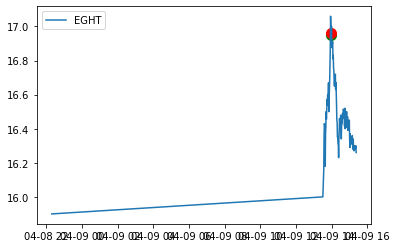

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


BRFS analysis for run 228 with profit 0.0


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1652.56,-1652.56,buy,2020-04-09 14:29:26.425692,3.64,"[2.86, 2.96, 3.09, 3.37]",[3.7],454,"{'rsi': 66.29440623756602, 'macd': [-0.0017963385254358144, 0.0002635032674453974, 0.0022731969425811016, 0.005816139885292948, 0.009722250283311862], 'sell_macd': [-0.0021703826601040532, -0.0007341152910513848, 0.0006543283119908594, 0.003026435946672734, 0.005614747922442209], 'slow macd': [0.020461911003440303, 0.020298168153113583, 0.02019502342252011, 0.02046766791720822, 0.020925678437243356], 'macd_signal': [-0.0022860699342066434, -0.0017761552938762352, -0.0009662848465847677, 0.00039020009979077563, 0.0022566101364949933], 'sell_macd_signal': [-0.00299662530225103, -0.0025441233000111007, -0.0019044329776107087, -0.00091825919275402, 0.00038834223028522607]}",4.03,3.51
1,0.00,1652.56,sell,2020-04-09 15:09:24.919294,3.64,None,None,454,"{'rsi': 46.00619147542454, 'reasons': 'below cost & macd negative', 'movement': 0.0, 'sell_macd': [0.0021838815355370578, 0.0011361264348144218, 0.0008244195195135084, 0.000570824267077441, -0.00015367624478246356], 'sell_macd_signal': [0.0064410647002139405, 0.005380077047134037, 0.004468945541609931, 0.003689321286703433, 0.0029207217804062538]}",4.03,3.51


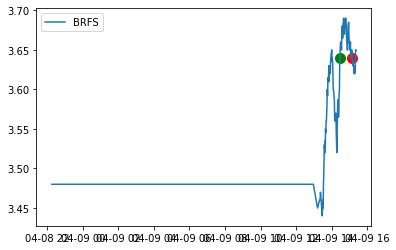

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


VSLR analysis for run 228 with profit -18.64


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1386.35,-1386.35,buy,2020-04-09 14:41:27.839575,5.95,"[4.09, 4.44, 4.5, 4.88, 5.19, 5.79]",[5.97],233,"{'rsi': 67.83646980838539, 'macd': [0.003978130499460164, 0.006748602163478168, 0.015224058855646483, 0.02248860117736573, 0.029120495005751756], 'sell_macd': [0.0007666888432869001, 0.0027007855139444814, 0.008328642848042023, 0.013125302551909357, 0.017471721768534287], 'slow macd': [0.03914405448167102, 0.038853461129419564, 0.03980345347326342, 0.04077375278125572, 0.041841151300475055], 'macd_signal': [0.0020341683837663787, 0.0029770551397087365, 0.005426455882896286, 0.008838884941790175, 0.012895206954582492], 'sell_macd_signal': [-0.0012380524859937282, -0.00045028488600608633, 0.0013055006608035358, 0.0036694610390247003, 0.006429913184926618]}",6.72,5.7
1,-18.64,1367.71,sell,2020-04-09 15:06:05.927555,5.87,None,None,233,"{'rsi': 38.01374244055807, 'reasons': 'below cost & macd negative', 'movement': -0.012594458438287184, 'sell_macd': [0.01471417702331923, 0.01161409830826532, 0.006450217513310541, 0.0024725153677183087, -0.0013084540362200414], 'sell_macd_signal': [0.020152534116522985, 0.018444846954871454, 0.01604592106655927, 0.013331239926791078, 0.010403301134188855]}",6.72,5.7


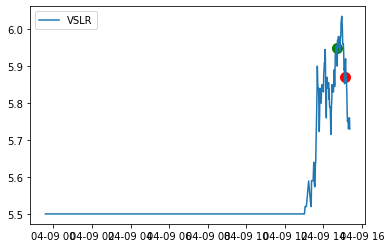

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


PSEC analysis for run 228 with profit 31.52


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1808.46,-1808.46,buy,2020-04-09 14:35:25.021003,4.59,"[3.96, 4.54]",[4.68],394,"{'rsi': 63.434996928515716, 'macd': [0.011447678123782445, 0.013660919822830131, 0.016834702694472625, 0.017541971865195904, 0.02028137680675801], 'sell_macd': [0.005642512638795338, 0.007175764512687088, 0.009316275524645867, 0.009829449358320197, 0.011654916639646018], 'slow macd': [0.039806025188149796, 0.03965052377337752, 0.03976391407706181, 0.03948636726877286, 0.0396460711172546], 'macd_signal': [0.0064113610531160835, 0.007861272807058893, 0.00965595878454164, 0.011233161400672492, 0.013042804481889596], 'sell_macd_signal': [0.0017224009151954765, 0.002813073634693799, 0.004113714012684212, 0.005256861081811409, 0.0065364721933783305]}",5.04,4.44
1,31.52,1839.98,sell,2020-04-09 14:58:37.437306,4.67,None,None,394,"{'rsi': 64.12492741409133, 'reasons': 'bail', 'movement': 0.02069716775599123, 'sell_macd': [0.017206796102917643, 0.016657005028214655, 0.016531752177430192, 0.016219454473215933, 0.0160252036066435], 'sell_macd_signal': [0.02104941882851081, 0.020170936068451578, 0.0194430992902473, 0.018798370326841028, 0.018243736982801524]}",5.04,4.44


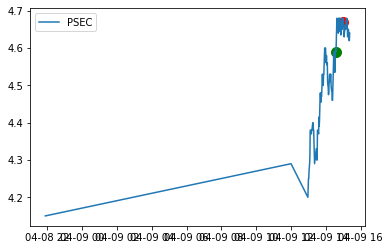

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


CLNY analysis for run 228 with profit -47.7


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1219.0,-1219.0,buy,2020-04-09 15:00:47.561806,2.30,"[1.34, 1.4, 1.45, 1.64, 1.79, 2.25]",[2.3],530,"{'rsi': 64.91073512620986, 'macd': [0.011012890262108055, 0.011059428282779393, 0.012565297919683971, 0.014798497231564234, 0.017177231766723366], 'sell_macd': [0.006275509960818049, 0.006305533137918928, 0.007285998819583028, 0.008734595469976458, 0.010269416295348055], 'slow macd': [0.03194975013801571, 0.03148695285351444, 0.03133067761838815, 0.031376694401075156, 0.03152878470069842], 'macd_signal': [0.011784902894382955, 0.011639807972062242, 0.011824905961586588, 0.012419624215582117, 0.013371145725810368], 'sell_macd_signal': [0.006780770459547307, 0.006685722995221631, 0.0068057781600939105, 0.00719154162207042, 0.007807116556725948]}",2.63,2.19
1,-47.7,1171.3,sell,2020-04-09 15:12:26.996642,2.21,None,None,530,"{'rsi': 39.335112519485655, 'reasons': 'below cost & macd negative', 'movement': -0.03695652173913042, 'sell_macd': [0.004071546248883617, 0.0030667348705133435, 0.0022439372396982904, 0.002093134706080413, -0.00038921966694749344], 'sell_macd_signal': [0.007281312006925632, 0.0064383965796431745, 0.005599504711654197, 0.004898230710539441, 0.0038407406350420537]}",2.63,2.19


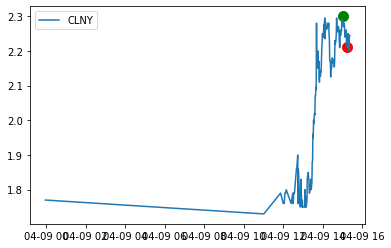

REPH analysis for run 228 with profit -2.8


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1194.2,-1194.2,buy,2020-04-09 14:04:23.957503,8.53,"[7.09, 7.83, 8.46]",[8.56],140,"{'rsi': 77.71146826327474, 'macd': [0.10519809196651231, 0.11251292672042901, 0.1169617240151446, 0.11751891022593064, 0.12140253007511248], 'sell_macd': [0.06635889487963098, 0.0707330512096096, 0.07322287365881941, 0.07317308759770036, 0.07530087654231288], 'slow macd': [0.03417481037465109, 0.03854613423638753, 0.042506242860500976, 0.04576181462085316, 0.04964347130301583], 'macd_signal': [0.07271749646461112, 0.0806765825157747, 0.08793361081564868, 0.09385067069770507, 0.09936104257318655], 'sell_macd_signal': [0.046221259768194425, 0.05112361805647746, 0.055543469176945845, 0.05906939286109675, 0.06231568959733998]}",9.82,8.11
1,-2.8,1191.4,sell,2020-04-09 14:06:59.890813,8.51,None,None,140,"{'rsi': 78.17494942123568, 'reasons': 'rsi max', 'movement': 0.0011709601873538132, 'sell_macd': [0.0707330512096096, 0.07322287365881941, 0.07317308759770036, 0.07530087654231288, 0.07650044095964326], 'sell_macd_signal': [0.05112361805647746, 0.055543469176945845, 0.05906939286109675, 0.06231568959733998, 0.06515263986980063]}",9.82,8.11


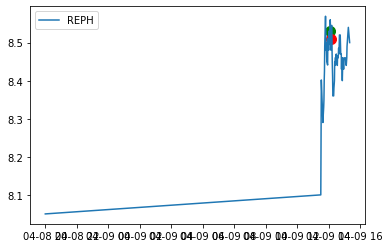

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


CVA analysis for run 228 with profit -18.81


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1448.37,-1448.37,buy,2020-04-09 14:43:40.121062,8.47,"[7.06, 7.19, 7.76, 8.37]",[8.55],171,"{'rsi': 71.50401571430456, 'macd': [0.04589942734439845, 0.05013394731549603, 0.05446772852002546, 0.05963558868289098, 0.06220715332692528], 'sell_macd': [0.02875671364957988, 0.03138091061580717, 0.034051961360713534, 0.037249507897515244, 0.03873786223921094], 'slow macd': [0.035481444320724975, 0.037025343559562884, 0.038704836072289694, 0.04066792800651342, 0.042249056686491926], 'macd_signal': [0.026832234719862978, 0.031492577238989586, 0.03608760749519676, 0.040797203732735605, 0.04507919365157354], 'sell_macd_signal': [0.016388675947139088, 0.019387122880872704, 0.02232009057684087, 0.025305974040975746, 0.027992351680622786]}",9.51,8.13
1,-18.81,1429.56,sell,2020-04-09 15:06:26.828764,8.36,None,None,171,"{'rsi': 40.76711604972171, 'reasons': 'below cost & macd negative', 'movement': -0.012987012987013128, 'sell_macd': [0.008658810235839809, 0.005332633158307232, 0.0026715518880440214, 4.380606851306368e-05, -0.0025238375060361307], 'sell_macd_signal': [0.017270910335928848, 0.014883254900404524, 0.012440914297932423, 0.009961492652048551, 0.007464426620431615]}",9.51,8.13


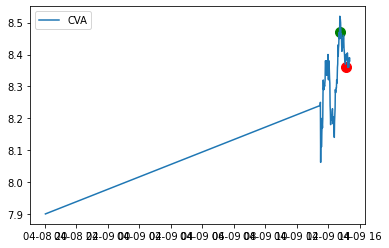

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


FULT analysis for run 228 with profit -18.9


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3248.1,-3248.1,buy,2020-04-09 14:41:08.288102,12.03,"[10.06, 10.41, 10.96, 11.93]",[12.08],270,"{'rsi': 62.0359507019281, 'macd': [-0.004432726890996719, 0.00397253639868822, 0.009714864772103482, 0.013305408486063541, 0.01836004634189159], 'sell_macd': [-0.00496047538586275, 0.0007131165547402674, 0.004605355514238241, 0.007058978657818571, 0.01043765930661067], 'slow macd': [0.04648110806652994, 0.046838002231549325, 0.04693150941458768, 0.046782542597521015, 0.04705047429825626], 'macd_signal': [-0.004626445002045796, -0.0029066487218989924, -0.00038234602309849706, 0.002355204878733911, 0.005556173171365446], 'sell_macd_signal': [-0.006166496649461938, -0.0047905740086214964, -0.002911388104049549, -0.0009173147516759249, 0.0013536800599813943]}",12.69,11.81
1,-18.9,3229.2,sell,2020-04-09 15:00:39.776843,11.96,None,None,270,"{'rsi': 43.542701378524214, 'reasons': 'below cost & macd negative', 'movement': -0.005818786367414673, 'sell_macd': [0.0031772872348998504, 0.002187641278609931, 0.0013880776597012812, 0.00022753357146498843, -0.0017187025176994553], 'sell_macd_signal': [0.010205025085744546, 0.008601548324317624, 0.007158854191394355, 0.005772590067408482, 0.004274331550386894]}",12.69,11.81


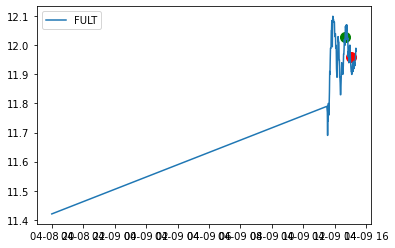

BRG analysis for run 228 with profit -24.4


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1490.84,-1490.84,buy,2020-04-09 14:51:48.407757,6.11,"[3.88, 3.98, 4.28, 4.55, 4.91, 5.32, 5.5, 5.79]","[6.18, 6.33]",244,"{'rsi': 55.25988332252266, 'macd': [0.006826446729353286, 0.013443082445731669, 0.021664741967730272, 0.0238707174682391, 0.024529294085809283], 'sell_macd': [0.0036385949101447324, 0.008034134888347921, 0.01343281363904758, 0.01486772157934535, 0.015273263849975294], 'slow macd': [0.026310944442726303, 0.027184845071640318, 0.02858512734546803, 0.029028033783970564, 0.02922915956560157], 'macd_signal': [-0.011343016118630724, -0.006385796405758246, -0.000775688731060542, 0.0041535925087993865, 0.008228732824201366], 'sell_macd_signal': [-0.009182331298542656, -0.005739038061164541, -0.001904667721122116, 0.001449810138971377, 0.004214500881172161]}",6.83,5.87
1,-24.40,1466.44,sell,2020-04-09 15:02:21.693487,6.01,None,None,244,"{'rsi': 45.58373166610538, 'reasons': 'below cost & macd negative', 'movement': -0.014729950900163788, 'sell_macd': [0.0038926805262953224, 0.00445857688133966, 0.0031065665491496475, 0.0009737459455063657, -0.0012203187579240549], 'sell_macd_signal': [0.006663313608046809, 0.006222366262705379, 0.005599206319994233, 0.00467411424509666, 0.0034952276444925167]}",6.83,5.87


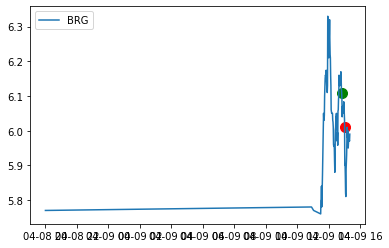

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


AZUL analysis for run 228 with profit -22.26


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1647.24,-1647.24,buy,2020-04-09 14:33:48.723928,10.36,"[7.76, 8.27, 9.06, 9.72, 10.11]",[10.4],159,"{'rsi': 69.97916674571051, 'macd': [0.00843466870745857, 0.019360136144678464, 0.030084532157946597, 0.03655652866796544, 0.04599690737333084], 'sell_macd': [0.004581191929714734, 0.01177210706022258, 0.01877577979749745, 0.022955579595407727, 0.029031325157474086], 'slow macd': [0.04178207247640131, 0.04312809105512727, 0.04477570256469576, 0.045901672685950246, 0.04782380405670672], 'macd_signal': [-0.007520317233867872, -0.0021442265581586043, 0.0043015251850624355, 0.010752525881643035, 0.017801402179980597], 'sell_macd_signal': [-0.006663503261828732, -0.002976381197418469, 0.0013740510015647156, 0.005690356720333318, 0.010358550407761472]}",11.47,9.99
1,-22.26,1624.98,sell,2020-04-09 15:00:42.248755,10.22,None,None,159,"{'rsi': 43.827959679084174, 'reasons': 'below cost & macd negative', 'movement': -0.011583011583011508, 'sell_macd': [0.002837513765571842, 0.0035339496835256057, 0.004030731571754487, 0.002287565100612454, -0.0006588966314531319], 'sell_macd_signal': [0.011846634032643976, 0.010184097162820302, 0.008953424044607139, 0.007620252255808202, 0.005964422478355935]}",11.47,9.99


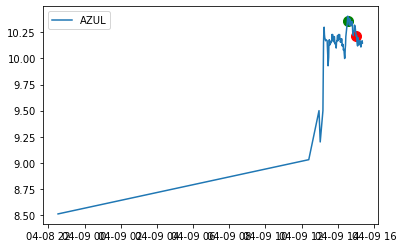

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


SGMS analysis for run 228 with profit -23.68


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-720.02,-720.02,buy,2020-04-09 13:58:08.118734,9.73,"[5.64, 5.79, 5.87, 6.02, 6.6, 6.78, 7.34, 7.96, 8.56, 8.87, 9.12, 9.39, 9.6]",[9.84],74,"{'rsi': 64.84222955986658, 'macd': [0.15598456009281847, 0.15118542141655844, 0.15687059286488392, 0.16352569194417121, 0.1700671434513712], 'sell_macd': [0.09859544614281113, 0.09483119742931834, 0.09793916989374907, 0.10168643194533367, 0.1053636954667585], 'slow macd': [0.03941102070072766, 0.04304602904007204, 0.048560611236261764, 0.05435621746916297, 0.06024116951715541], 'macd_signal': [0.12018724371259473, 0.12638687925338749, 0.13248362197568678, 0.13869203596938368, 0.14496705746578117], 'sell_macd_signal': [0.07749388348637973, 0.08096134627496746, 0.08435691099872378, 0.08782281518804576, 0.09133099124378831]}",12.14,8.94
1,-23.68,696.34,sell,2020-04-09 14:20:11.035215,9.41,None,None,74,"{'rsi': 44.16517119080217, 'reasons': 'below cost & macd negative', 'movement': -0.02566735112936345, 'sell_macd': [0.023991988560574384, 0.015543639942421805, 0.010317087253699952, 0.0035130580514000087, -0.0028733680549564156], 'sell_macd_signal': [0.05019711681681952, 0.04326642144193998, 0.03667655460429197, 0.03004385529371358, 0.02346041062397958]}",12.14,8.94


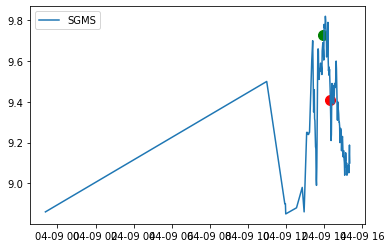

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


IHRT analysis for run 228 with profit -41.52


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1278.47,-1278.47,buy,2020-04-09 14:36:24.563995,7.39,"[4.43, 4.85, 5.07, 5.38, 5.52, 5.75, 5.94, 6.12, 6.48, 7.17]",[],173,"{'rsi': 62.56871215277647, 'macd': [0.04317274626991807, 0.052901181626900495, 0.06869524144645212, 0.08108437388118439, 0.08268743349379548], 'sell_macd': [0.02370904208696345, 0.030154301392362193, 0.04049925278108457, 0.04855377006085426, 0.049524124174169515], 'slow macd': [0.07328699880869927, 0.0749970861422753, 0.07820977011268315, 0.08120039255788747, 0.08238256795820043], 'macd_signal': [0.034045718784417416, 0.03781681135291403, 0.04399249737162165, 0.0514108726735342, 0.057666184837586454], 'sell_macd_signal': [0.016944989544357275, 0.01958685191395826, 0.02376933208738352, 0.02872621968207767, 0.03288580058049604]}",8.42,7.06
1,-41.52,1236.95,sell,2020-04-09 14:49:24.194726,7.15,None,None,173,"{'rsi': 44.65086580450722, 'reasons': 'below cost & macd negative', 'movement': -0.029729729729729815, 'sell_macd': [0.018321345663045108, 0.011501501928450786, 0.0060379678245015, 0.0011827728366897716, -0.0026158566711718123], 'sell_macd_signal': [0.03331089489605696, 0.028949016302535723, 0.02436680660692888, 0.01972999985288106, 0.015260828548070485]}",8.42,7.06


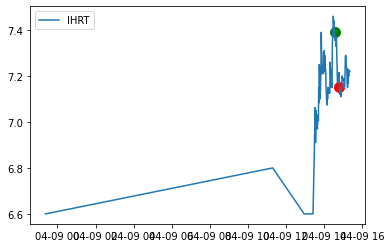

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


IVZ analysis for run 228 with profit -23.1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1683.0,-1683.0,buy,2020-04-09 14:41:23.920224,10.20,"[7.75, 8.39, 9.41, 9.82]",[10.36],165,"{'rsi': 66.77780221249758, 'macd': [-0.006265077150134246, -0.0028679896111327707, 0.006207996234079971, 0.01604008775116661, 0.02515594192835735], 'sell_macd': [-0.0037232704137100114, -0.0014234886129411706, 0.004542880174838615, 0.010951182085124245, 0.01684140198813644], 'slow macd': [0.039138833798734396, 0.03845111127216505, 0.03903637557495365, 0.040072180316423456, 0.04128093600968796], 'macd_signal': [-0.02526726811305314, -0.020787412412669064, -0.015388330683319257, -0.009102646996422084, -0.0022509292114661975], 'sell_macd_signal': [-0.01726944554348267, -0.01410025415737437, -0.010371627290931773, -0.006107065415720569, -0.0015173719349491667]}",11.28,9.84
1,-23.1,1659.9,sell,2020-04-09 14:57:39.526212,10.06,None,None,165,"{'rsi': 44.11668049029588, 'reasons': 'below cost & macd negative', 'movement': -0.011764705882352865, 'sell_macd': [0.007618758328323594, 0.005196840677488268, 0.0038811017199886777, 0.0012470051073911748, -0.0008217325791441965], 'sell_macd_signal': [0.015420776809510605, 0.013375989583106138, 0.011477012010482646, 0.009431010629864352, 0.007380461988062642]}",11.28,9.84


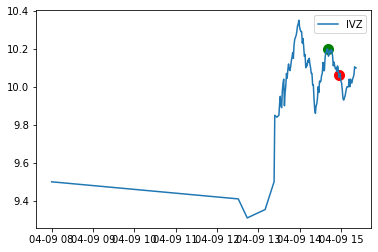

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


RUBI analysis for run 228 with profit -30.15


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1973.15,-1973.15,buy,2020-04-09 14:50:39.306448,5.89,"[4.11, 4.2, 4.27, 4.47, 4.79, 4.93, 5.01, 5.4, 5.85]",[5.94],335,"{'rsi': 66.93247597021612, 'macd': [-0.0057871626800718445, -0.0006690808066682763, 0.005741599644649931, 0.010698781198877683, 0.015258410266162592], 'sell_macd': [-0.0037431093008217786, -0.0003482701919006459, 0.0038600235318293485, 0.007089083270685137, 0.010032648219524987], 'slow macd': [0.024064726732630604, 0.024188551730113694, 0.024743596557097902, 0.0252146816273342, 0.025767703626576655], 'macd_signal': [-0.012395995561653014, -0.010050612610656066, -0.006892170159594866, -0.003373979887900356, 0.00035249814291223383], 'sell_macd_signal': [-0.008617804036855824, -0.006963897267864788, -0.0047991131079259605, -0.0024214738322037408, 6.93505781420049e-05]}",6.41,5.71
1,-30.15,1943.00,sell,2020-04-09 15:05:11.007521,5.80,None,None,335,"{'rsi': 44.83833366854398, 'reasons': 'below cost & macd negative', 'movement': -0.013582342954159604, 'sell_macd': [0.008573119276446661, 0.006470121258322692, 0.0038538874616236285, 0.0007262521984605641, -0.0006813369961919946], 'sell_macd_signal': [0.009385249892958022, 0.008802224166030955, 0.00781255682514949, 0.006395295899811705, 0.004979969320610965]}",6.41,5.71


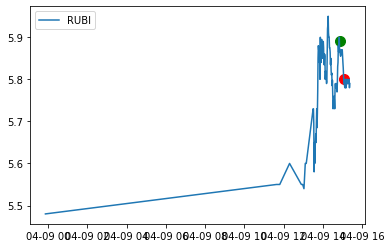

CUK analysis for run 228 with profit -22.25


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1104.49,-1104.49,buy,2020-04-09 14:45:17.716045,12.41,"[7.68, 8.49, 8.68, 8.94, 9.36, 10.49, 11.09, 11.6, 12.21]",[12.52],89,"{'rsi': 64.11613713876827, 'macd': [0.05601643302909842, 0.0570625865503569, 0.060422819804330175, 0.06476006443574356, 0.06981334653231208], 'sell_macd': [0.03501949539645821, 0.03557096206078647, 0.03761663787635783, 0.04028058477321217, 0.043391704630849404], 'slow macd': [0.08767403418135089, 0.0874553022857878, 0.08775393351296401, 0.08836814171755591, 0.08927170849560184], 'macd_signal': [0.027600586337466374, 0.03349298638004448, 0.03887895306490162, 0.04405517533907001, 0.049206809577718426], 'sell_macd_signal': [0.01608157302869265, 0.019979450835111413, 0.023506888243360696, 0.02686162754933099, 0.03016764296563467]}",14.39,11.75
1,-22.25,1082.24,sell,2020-04-09 14:59:36.593992,12.16,None,None,89,"{'rsi': 44.85566348937474, 'reasons': 'below cost & macd negative', 'movement': -0.016776792908944377, 'sell_macd': [0.004688063380186236, 0.0026535685540434173, 0.0010337859810221062, 0.002355594547747586, -0.0012268350697119956], 'sell_macd_signal': [0.017138127821238247, 0.014241215967799281, 0.011599729970443846, 0.009750902885904595, 0.007555355294781277]}",14.39,11.75


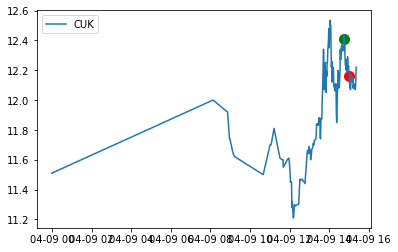

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


BBCP analysis for run 228 with profit -63.15


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1178.80,-1178.80,buy,2020-04-09 13:56:17.030422,2.80,"[1.98, 2.0, 2.07, 2.17, 2.24, 2.35, 2.42, 2.55, 2.67, 2.8]",[2.8],421,"{'rsi': 61.29403208672147, 'macd': [0.046484438801372985, 0.04410793588737283, 0.06487725199876992, 0.06924207514019187, 0.07027728329782823], 'sell_macd': [0.03012944316234023, 0.02834901930142264, 0.04165844201627378, 0.0442156747549074, 0.044595133060922], 'slow macd': [0.010521598636962448, 0.011395490115242435, 0.016819417476722442, 0.01954359947946438, 0.021698804753511602], 'macd_signal': [0.031639869199497364, 0.034133482537072456, 0.04028223642941195, 0.046074204171567934, 0.050914819996819995], 'sell_macd_signal': [0.021147821311962633, 0.022588060909854636, 0.026402137131138464, 0.02996484465589225, 0.0328909023368982]}",3.27,2.7
1,-63.15,1115.65,sell,2020-04-09 14:20:09.315070,2.65,None,None,421,"{'rsi': 43.70176264005982, 'reasons': 'stopped', 'movement': -0.06338028169014075, 'sell_macd': [0.027277358650434014, 0.023791362654238757, 0.018168620804550617, 0.013551307404735091, 0.007699487776245295], 'sell_macd_signal': [0.03387674470124624, 0.031859668291844744, 0.029121458794385918, 0.026007428516455752, 0.02234584036841366]}",3.27,2.7


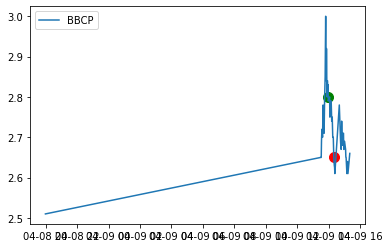

VG analysis for run 228 with profit 118.44


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-8142.75,-8142.75,buy,2020-04-09 14:46:02.460119,8.25,"[6.81, 7.01, 7.76, 8.21]",[8.31],987,"{'rsi': 64.9065933674697, 'macd': [0.011933330751320526, 0.013090946304824769, 0.014646446282016612, 0.01649595257432246, 0.019751309896507863], 'sell_macd': [0.007847433107000867, 0.008573251269607951, 0.009546963457747637, 0.010701194208794007, 0.012760319544559806], 'slow macd': [0.022524717960017426, 0.02253152772088285, 0.022661692914352827, 0.022905140870577156, 0.023492327269535096], 'macd_signal': [-0.002010672985498016, 0.0010096508725665411, 0.0037370099544565554, 0.006288798478429737, 0.008981300762045362], 'sell_macd_signal': [-0.001613163165764861, 0.00042411972130970135, 0.0022486884685972886, 0.0039391896166366324, 0.0057034156022212675]}",8.43,8.19
1,118.44,8261.19,sell,2020-04-09 14:55:52.632036,8.37,None,None,987,"{'rsi': 78.97953981463692, 'reasons': 'rsi max', 'movement': 0.015757575757575852, 'sell_macd': [0.024501937715839972, 0.026372756694948762, 0.02826725516315065, 0.02942832857781319, 0.03119762827004635], 'sell_macd_signal': [0.017873362014534648, 0.019573240950617472, 0.021312043793124107, 0.022935300750061925, 0.02458776625405881]}",8.43,8.19


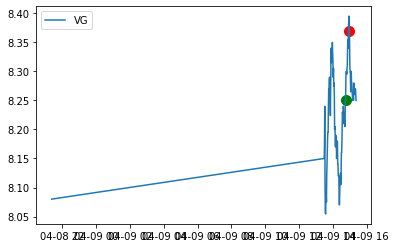

TROX analysis for run 228 with profit -26.78


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1190.68,-1190.68,buy,2020-04-09 13:50:37.617775,5.78,"[4.18, 4.36, 4.48, 4.82, 5.26]",[5.88],206,"{'rsi': 65.24792442041812, 'macd': [0.09061104158223277, 0.08807314822706669, 0.08547994804023151, 0.08686157241760917, 0.08815074738657902], 'sell_macd': [0.05532239425788976, 0.053421542217563456, 0.05150631280669149, 0.05220215595657418, 0.05284564209990439], 'slow macd': [0.04934910299751838, 0.050905377561110576, 0.052335751915601136, 0.05444768649457732, 0.05654355643470055], 'macd_signal': [0.07939109182168069, 0.08112750310275789, 0.08199799209025262, 0.08297070815572392, 0.08400671600189494], 'sell_macd_signal': [0.048971982602830026, 0.04986189452577671, 0.05019077818195967, 0.05059305373688257, 0.05104357140948693]}",6.65,5.5
1,-26.78,1163.90,sell,2020-04-09 14:14:51.194891,5.65,None,None,206,"{'rsi': 43.553123189491906, 'reasons': 'below cost & macd negative', 'movement': -0.023336214347450264, 'sell_macd': [0.008466956538248027, 0.006562840438143702, 0.004993881912891851, 0.0031869806995414862, -0.0003403057095567874], 'sell_macd_signal': [0.02422168114204834, 0.020689913001267414, 0.0175507067835923, 0.014677961566782138, 0.011674308111514353]}",6.65,5.5


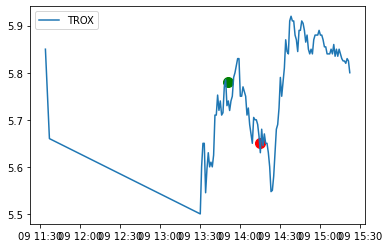

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


BSGM analysis for run 228 with profit -21.98


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-794.42,-794.42,buy,2020-04-09 13:55:00.710957,5.06,"[3.57, 3.69, 3.78, 3.87, 3.97, 4.24, 4.49, 4.93]","[5.39, 5.94]",157,"{'rsi': 70.67187692480942, 'macd': [0.04213114304831578, 0.052434824104111044, 0.06673845086743757, 0.07639470031599771, 0.0878678906210979], 'sell_macd': [0.02494287169071363, 0.031581699389489515, 0.04079141318867219, 0.046923769224545886, 0.05420451718464836], 'slow macd': [0.03536298101369084, 0.03808561353346818, 0.04189866230350958, 0.045181441420123925, 0.049087458605909795], 'macd_signal': [0.041826369473596386, 0.04394806039969932, 0.04850613849324697, 0.054083850857797114, 0.06084065881045727], 'sell_macd_signal': [0.02513336738870577, 0.02642303378886252, 0.02929670966882445, 0.032822121579968735, 0.03709860070090466]}",6.23,4.71
1,-21.98,772.44,sell,2020-04-09 14:53:38.699975,4.92,None,None,157,"{'rsi': 37.75657186590302, 'reasons': 'below cost & macd negative', 'movement': -0.03534450578596828, 'sell_macd': [0.003956115003968641, 0.002786341763505007, 0.0018386438908901681, 0.0005568190045552868, -0.0061635227121277225], 'sell_macd_signal': [0.00561382972632323, 0.005048332133759585, 0.004406394485185702, 0.0036364793890596185, 0.00167647896882215]}",6.23,4.71


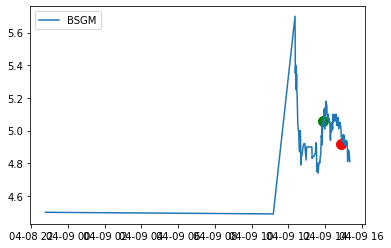

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


CENX analysis for run 228 with profit -31.77


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1503.78,-1503.78,buy,2020-04-09 14:43:05.219719,4.26,"[2.94, 3.01, 3.19, 3.44, 3.79, 3.91, 4.16, 4.24]",[4.28],353,"{'rsi': 67.51817142667403, 'macd': [0.005358126926073403, 0.011032766276952266, 0.01654956045468481, 0.02068323611581757, 0.0234947115071229], 'sell_macd': [0.0021502791702294743, 0.005937609026271495, 0.009590884121547738, 0.012313035051353616, 0.014149606749236376], 'slow macd': [0.029706790545796835, 0.03028253896780342, 0.031003717281744336, 0.03161763828584352, 0.032093512607030306], 'macd_signal': [0.00028914357682080743, 0.002437868116847099, 0.005260206584414642, 0.008344812490695228, 0.011374792293980761], 'sell_macd_signal': [-0.0017687279910804782, -0.00022746058761008328, 0.0017362083542214809, 0.003851573693647908, 0.005911180304765602]}",4.77,4.1
1,-31.77,1472.01,sell,2020-04-09 15:05:05.427318,4.17,None,None,353,"{'rsi': 34.11265742511777, 'reasons': 'below cost & macd negative', 'movement': -0.02406981654389335, 'sell_macd': [0.007617177121370666, 0.006634818288397071, 0.005263696882333413, 0.003087969853162953, -0.0007254274403871719], 'sell_macd_signal': [0.010170386766595117, 0.009463273070955508, 0.00862335783323109, 0.007516280237217463, 0.005867938701696536]}",4.77,4.1


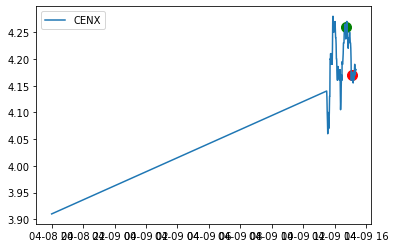

SHLX analysis for run 228 with profit -22.54


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1123.08,-1123.08,buy,2020-04-09 14:45:56.387850,11.46,"[8.76, 9.07, 9.39, 10.23, 11.27]",[11.56],98,"{'rsi': 64.79860264440482, 'macd': [0.12462033576669285, 0.1312269786304121, 0.13199597826859133, 0.1422463799421667, 0.14548135128252326], 'sell_macd': [0.07747441692999324, 0.08148446587074076, 0.08165483561845654, 0.08798947651773581, 0.08971530739356837], 'slow macd': [0.105841115614556, 0.10880965130111697, 0.11078300676276065, 0.1146572806092987, 0.1174018127958032], 'macd_signal': [0.06613337699584113, 0.07915209732275533, 0.08972087351192252, 0.10022597479797136, 0.10927705009488174], 'sell_macd_signal': [0.0390272104803843, 0.04751866155845559, 0.05434589637045578, 0.061074612399911785, 0.0668027513986431]}",13.34,10.94
1,-22.54,1100.54,sell,2020-04-09 15:05:06.443977,11.23,None,None,98,"{'rsi': 43.55265728612071, 'reasons': 'below cost & macd negative', 'movement': -0.028596187175043183, 'sell_macd': [0.019345315940888952, 0.013506258616097, 0.006183535264101536, 0.001176432194180066, -0.004039186200486711], 'sell_macd_signal': [0.03686021966781487, 0.0321894274574713, 0.026988249018797345, 0.02182588565387389, 0.016652871283001767]}",13.34,10.94


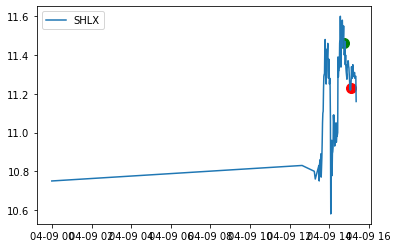

AAL analysis for run 228 with profit 11.2


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-735.84,-735.84,buy,2020-04-09 14:04:38.248057,13.14,"[9.38, 9.82, 10.62, 11.84, 12.85]",[],56,"{'rsi': 74.01898900012652, 'macd': [0.18365765985837967, 0.1897467372218138, 0.19079149313650667, 0.19421411964361468, 0.20795647238116466], 'sell_macd': [0.1014288332274269, 0.10559428874207377, 0.1064505620165761, 0.10884700142506354, 0.11794491523135164], 'slow macd': [0.21275387601811957, 0.21571520867906457, 0.21778124851037894, 0.2202917773619646, 0.2249105537626246], 'macd_signal': [0.20084106044054229, 0.19862219579679657, 0.1970560552647386, 0.19648766814051383, 0.19878142898864398], 'sell_macd_signal': [0.1125868343608213, 0.1111883252370718, 0.11024077259297266, 0.10996201835939083, 0.11155859773378299]}",16.35,12.08
1,11.20,747.04,sell,2020-04-09 14:06:37.511916,13.34,None,None,56,"{'rsi': 79.82363352881939, 'reasons': 'rsi max', 'movement': 0.018537535276085322, 'sell_macd': [0.1064505620165761, 0.10884700142506354, 0.11657868146511774, 0.12732312459418438, 0.14183407866106634], 'sell_macd_signal': [0.11024077259297266, 0.10996201835939083, 0.11128535098053621, 0.11449290570326584, 0.11996114029482594]}",16.35,12.08


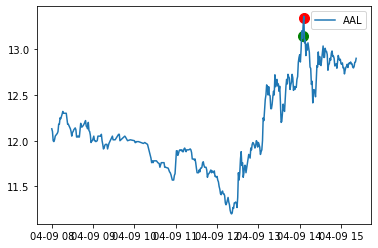

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


CAL analysis for run 228 with profit -54.52


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1188.16,-1188.16,buy,2020-04-09 14:04:47.362691,6.32,"[3.3, 3.4, 3.45, 3.58, 3.8, 3.92, 4.12, 5.54, 5.89, 6.1]","[6.34, 6.43, 6.63]",188,"{'rsi': 65.43810800827627, 'macd': [0.09490399295664087, 0.09949844788212214, 0.09877332341767442, 0.10027046723136745, 0.10428936375512787], 'sell_macd': [0.0607751213943688, 0.06336789692648281, 0.06248735971869568, 0.06306762475524241, 0.06529812186482076], 'slow macd': [0.012080170214615826, 0.016088242473388803, 0.019110322160531545, 0.022499911953203444, 0.02638213764897568], 'macd_signal': [0.057703046883416306, 0.06606212708315748, 0.07260436635006087, 0.07813758652632219, 0.08336794197208333], 'sell_macd_signal': [0.03752684591487419, 0.042695056117195915, 0.04665351683749587, 0.04993633842104518, 0.053008695109800295]}",7.3,6.03
1,-54.52,1133.64,sell,2020-04-09 14:20:07.361374,6.03,None,None,188,"{'rsi': 41.846268827135354, 'reasons': 'below cost & macd negative', 'movement': -0.045669291338582683, 'sell_macd': [0.020715335775753907, 0.012456620143534991, 0.008197145363318725, 0.0013949942960937989, -0.004442980487406878], 'sell_macd_signal': [0.032355238951377895, 0.028375515189809315, 0.024339841224511195, 0.019750871838827715, 0.014912101373580795]}",7.3,6.03


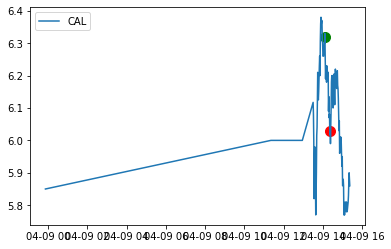

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


HOMB analysis for run 228 with profit -21.48


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2436.19,-2436.19,buy,2020-04-09 14:42:39.515062,13.61,"[11.17, 11.89, 12.74, 13.5]",[13.68],179,"{'rsi': 61.537798414318246, 'macd': [0.007487316703464586, 0.014266377541126474, 0.021010469336546933, 0.025656005992940933, 0.030997597322103942], 'sell_macd': [0.002765458794179665, 0.007358074744534093, 0.011880138150724306, 0.014989796153590973, 0.018516934907077953], 'slow macd': [0.06573462505843253, 0.06563648343074391, 0.06576108566223837, 0.06569058002130035, 0.06592048973746323], 'macd_signal': [-0.006583428130218005, -0.002413466995949109, 0.0022713202705501, 0.006948257415028267, 0.011758125396443404], 'sell_macd_signal': [-0.007825796614313625, -0.004789022342544082, -0.0014551902438904047, 0.0018338070356058705, 0.005170432609900287]}",14.6,13.28
1,-21.48,2414.71,sell,2020-04-09 15:00:51.748273,13.49,None,None,179,"{'rsi': 45.997500564821905, 'reasons': 'below cost & macd negative', 'movement': -0.008082292432035227, 'sell_macd': [0.002717175167719077, 0.003019743617789672, 0.002696813272159204, 0.0008517141291726205, -0.0011165672047024344], 'sell_macd_signal': [0.010817018809250515, 0.009257563770958346, 0.007945413671198517, 0.006526673762793337, 0.004998025569294183]}",14.6,13.28


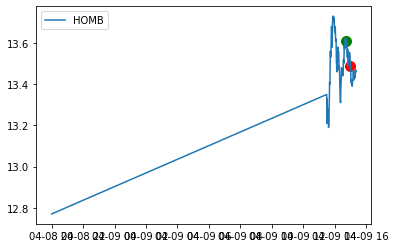

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


HIE analysis for run 228 with profit -51.12


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1237.53,-1237.53,buy,2020-04-09 14:02:29.036608,5.81,"[4.97, 5.28, 5.46, 5.68]",[],213,"{'rsi': 69.75142021348304, 'macd': [0.07275990750733907, 0.07928256965453784, 0.08428713322109438, 0.08724755045163146, 0.0885647143735433], 'sell_macd': [0.04558639831189293, 0.04957075331591643, 0.052551150029234606, 0.054191054610661205, 0.05475992760124537], 'slow macd': [0.029138347069267212, 0.03231324563786142, 0.035342509381877996, 0.03807300351920517, 0.04052265365751406], 'macd_signal': [0.055238596080310745, 0.06004739079515616, 0.0648953392803438, 0.06936578151460134, 0.07320556808638973], 'sell_macd_signal': [0.03502280569444426, 0.037932395218738695, 0.040856146180837875, 0.04352312786680254, 0.045770487813691106]}",6.66,5.54
1,-51.12,1186.41,sell,2020-04-09 14:29:11.580690,5.57,None,None,213,"{'rsi': 40.731681497518494, 'reasons': 'below cost & macd negative', 'movement': -0.041220639529888754, 'sell_macd': [0.02185064735084641, 0.012749774349064324, 0.005492603511973115, 0.0018442547621360106, -0.0036199683515301118], 'sell_macd_signal': [0.032998741821006164, 0.028948948326617797, 0.02425767936368886, 0.01977499444337829, 0.01509600188439661]}",6.66,5.54


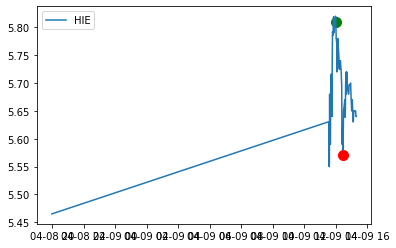

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


TEN analysis for run 228 with profit 11.7


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-487.89,-487.89,buy,2020-04-09 13:50:50.536803,4.17,"[2.4, 2.47, 2.52, 2.67, 2.84, 3.02, 3.18, 3.49]",[4.24],117,"{'rsi': 74.85720149952307, 'macd': [0.13260705335522127, 0.13581650083697383, 0.13679123603393695, 0.14158008855538773, 0.14451631103167628], 'sell_macd': [0.08298130973128481, 0.0846066594278887, 0.08477957270539926, 0.08744964054884408, 0.08891398379634818], 'slow macd': [0.050285560710508825, 0.054428316813898814, 0.058154333817755255, 0.06260893109508503, 0.06676710486987725], 'macd_signal': [0.09888716311386758, 0.10627303065848884, 0.11237667173357846, 0.11821735509794032, 0.1234771462846875], 'sell_macd_signal': [0.0624250814245227, 0.0668613970251959, 0.07044503216123657, 0.07384595383875807, 0.07685955983027609]}",5.7,3.66
1,11.70,499.59,sell,2020-04-09 14:02:17.071519,4.27,None,None,117,"{'rsi': 75.52702846008769, 'reasons': 'bail', 'movement': 0.025035971223021595, 'sell_macd': [0.08406894267190257, 0.08181024955365412, 0.07769425167510136, 0.0747766656440847, 0.07331910944272035], 'sell_macd_signal': [0.08520799242083371, 0.0845284438473978, 0.08316160541293852, 0.08148461745916775, 0.07985151585587827]}",5.7,3.66


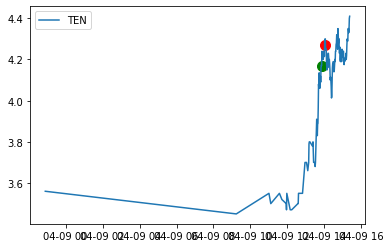

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


SDC analysis for run 228 with profit -17.78


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-614.68,-614.68,buy,2020-04-09 13:55:21.343433,4.84,"[3.75, 4.13, 4.57, 4.74]",[4.88],127,"{'rsi': 69.52746078349628, 'macd': [0.09060592079244323, 0.08600502035024693, 0.08945326051262636, 0.0950682263320104, 0.10077717987902624], 'sell_macd': [0.05618496325927769, 0.05288176272860934, 0.054852232929015976, 0.05823633655363114, 0.06167542591627129], 'slow macd': [0.03427104043249596, 0.035785552957457334, 0.03873227471199758, 0.04216989072893096, 0.04574497065378047], 'macd_signal': [0.07685975070855333, 0.07868880463689205, 0.08084169581203891, 0.0836870019160332, 0.08710503750863181], 'sell_macd_signal': [0.048370204403271326, 0.04927251606833893, 0.050388459440474334, 0.0519580348631057, 0.05390151307373882]}",6.29,4.41
1,-17.78,596.90,sell,2020-04-09 14:23:24.890659,4.70,None,None,127,"{'rsi': 43.482393961716156, 'reasons': 'below cost & macd negative', 'movement': -0.03586065573770488, 'sell_macd': [0.0066302757925855715, 0.006215537476977673, 0.0060298253157631265, 0.0029860259003262613, -0.0001985713831347269], 'sell_macd_signal': [0.008629950928858373, 0.008147068238482233, 0.007723619653938411, 0.006776100903215981, 0.00538116644594584]}",6.29,4.41


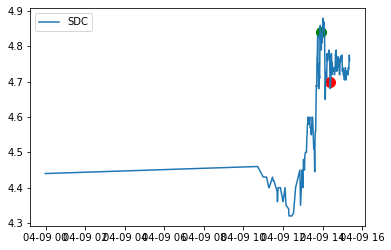

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


BCEI analysis for run 228 with profit -53.13


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1142.64,-1142.64,buy,2020-04-09 14:51:05.764339,16.56,"[12.56, 13.66, 14.82, 16.04, 16.55]",[16.7],69,"{'rsi': 71.89725123522994, 'macd': [0.13410199691625557, 0.15767983032103494, 0.1783441746658525, 0.19649037978311767, 0.20607512305410225], 'sell_macd': [0.0766569871686027, 0.09211273352377702, 0.10555730557295462, 0.11726012398045782, 0.1232979029475949], 'slow macd': [0.17539084967303964, 0.18060992780296203, 0.18592246641381394, 0.19131249499354652, 0.19548570802113296], 'macd_signal': [0.10253517108966244, 0.11356410293593694, 0.12652011728192006, 0.14051416978215958, 0.15362636043654812], 'sell_macd_signal': [0.05483511087213756, 0.062290635402465454, 0.07094396943656328, 0.08020720034534219, 0.08882534086579273]}",19.12,15.72
1,-53.13,1089.51,sell,2020-04-09 15:08:53.880110,15.79,None,None,69,"{'rsi': 39.087876860052866, 'reasons': 'below cost & macd negative', 'movement': -0.0419432709716355, 'sell_macd': [0.08087249127647311, 0.052060541803847116, 0.029453041671878566, 0.003662092975904585, -0.01466412799467065], 'sell_macd_signal': [0.1064944256695546, 0.0956076488964131, 0.08237672745150619, 0.06663380055638587, 0.05037421484617457]}",19.12,15.72


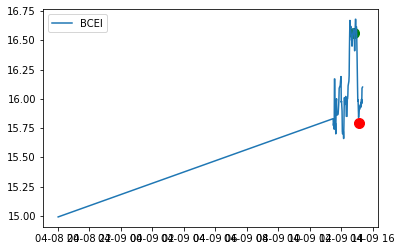

AUY analysis for run 228 with profit -29.52


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1795.80,-1795.80,buy,2020-04-09 14:36:52.798816,3.65,"[3.24, 3.54, 3.64]",[3.68],492,"{'rsi': 68.71041793212083, 'macd': [-0.006271375797709755, -0.0036934639640708866, 0.00015525287384043907, 0.004764301645721503, 0.008321085707500675], 'sell_macd': [-0.004567532177253142, -0.002802021467683602, -0.00022627258402341255, 0.0028227041121278162, 0.005161871614165925], 'slow macd': [0.01739939243463784, 0.01723244884363595, 0.0174095512033845, 0.017864518946274277, 0.01825453202128635], 'macd_signal': [-0.00783465135161453, -0.007006413874105802, -0.005574080524516554, -0.0035064040904689425, -0.0011409061308750188], 'sell_macd_signal': [-0.006103668935036446, -0.005443339441565878, -0.0043999260700573846, -0.0029554000336203443, -0.0013319457040630903]}",4.01,3.53
1,-29.52,1766.28,sell,2020-04-09 14:52:08.069377,3.59,None,None,492,"{'rsi': 40.74963706993368, 'reasons': 'below cost & macd negative', 'movement': -0.015068493150684854, 'sell_macd': [0.007219888884684167, 0.004051855859752873, 0.0025695982317577304, 0.000861740362777752, -0.0007399896697100061], 'sell_macd_signal': [0.00829969614103953, 0.007450128084782198, 0.006474022114177304, 0.005351565763897394, 0.004133254677175914]}",4.01,3.53


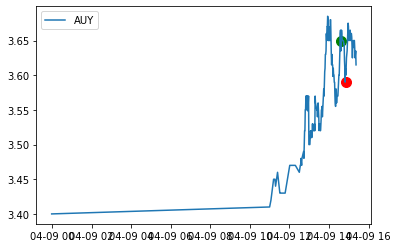

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


TGI analysis for run 228 with profit -48.76


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1702.36,-1702.36,buy,2020-04-09 14:48:33.138769,8.03,"[4.51, 4.64, 5.18, 5.55, 6.8, 7.18, 7.6, 7.8, 7.94]",[8.06],212,"{'rsi': 62.27167589229254, 'macd': [0.010705936138506011, 0.010225066776936131, 0.012922675490498747, 0.018079802824594537, 0.02590285355273725], 'sell_macd': [0.001980867984229917, 0.0019675173796942502, 0.0040094842153841626, 0.007626478058579522, 0.012943272247321502], 'slow macd': [0.08304436414150906, 0.0813220356835167, 0.08024711928024875, 0.07976956185480333, 0.08000229360875366], 'macd_signal': [0.02004809036594141, 0.018083485648140354, 0.017051323616612032, 0.017257019458208532, 0.018986186277114275], 'sell_macd_signal': [0.0068528508249880256, 0.005875784135929271, 0.005502524151820249, 0.005927314933172103, 0.0073305063960019835]}",8.87,7.75
1,-48.76,1653.60,sell,2020-04-09 14:52:39.015466,7.80,None,None,212,"{'rsi': 41.4406966007075, 'reasons': 'below cost & macd negative', 'movement': -0.028642590286425847, 'sell_macd': [0.012943272247321502, 0.012762290157414036, 0.01089707956583208, 0.0067047456040043585, -0.00028544638708272174], 'sell_macd_signal': [0.0073305063960019835, 0.008416863148284394, 0.00891290643179393, 0.008471274266236017, 0.006719930135572269]}",8.87,7.75


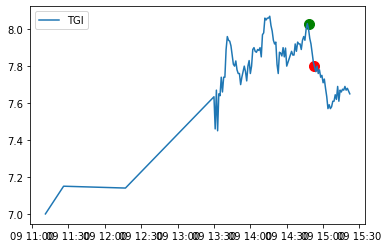

OII analysis for run 228 with profit -26.69


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-678.24,-678.24,buy,2020-04-09 14:01:31.638840,4.32,"[2.69, 2.73, 2.8, 2.87, 2.95, 3.02, 3.17, 3.27, 3.61, 3.74, 3.92, 4.22]",[4.39],157,"{'rsi': 59.26745681345514, 'macd': [0.06616884288405434, 0.06802667705218379, 0.07110017473886998, 0.0742933689408165, 0.07674623198859987], 'sell_macd': [0.03822551323733947, 0.039393242975063636, 0.04135000325153637, 0.043376699528637985, 0.044912090140292626], 'slow macd': [0.06032060104311032, 0.06166140754388305, 0.06327618168546767, 0.06498049618888313, 0.06660452885085988], 'macd_signal': [0.06710167901247878, 0.06728667862041979, 0.06804937784410983, 0.06929817606345116, 0.07078778724848091], 'sell_macd_signal': [0.03918127606551332, 0.03922366944742338, 0.03964893620824598, 0.04039448887232438, 0.04129800912591803]}",5.46,3.94
1,-26.69,651.55,sell,2020-04-09 14:23:27.102109,4.15,None,None,157,"{'rsi': 39.622532320143215, 'reasons': 'below cost & macd negative', 'movement': -0.03935185185185183, 'sell_macd': [0.007916438708906348, 0.006662450665460895, 0.006118272311276485, 0.0035368570702072333, -0.0005984906120568567], 'sell_macd_signal': [0.014542416871122019, 0.012966423629989794, 0.011596793366247133, 0.009984806107039152, 0.00786814676321995]}",5.46,3.94


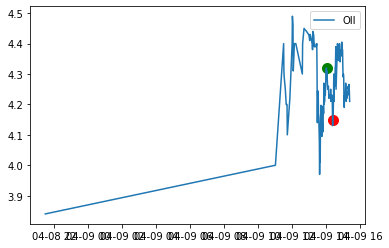

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


GME analysis for run 228 with profit 23.85


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-980.50,-980.50,buy,2020-04-09 14:00:08.100356,3.70,"[2.62, 2.72, 2.79, 2.97, 3.18, 3.39, 3.59]","[3.82, 3.89]",265,"{'rsi': 71.44678160065901, 'macd': [0.045647086595192565, 0.04806007740875229, 0.04944279012696873, 0.05072049621529251, 0.0515423970398734], 'sell_macd': [0.028476678642208597, 0.02988544366527668, 0.030621034025261284, 0.031290052045700456, 0.031664740736358166], 'slow macd': [0.012326163812655722, 0.014161810410445508, 0.01583601096217402, 0.01750294076052583, 0.019088544000416263], 'macd_signal': [0.036082857172106804, 0.0384783012194359, 0.040671199000942466, 0.042681058443812474, 0.04445332616302466], 'sell_macd_signal': [0.022855225423540543, 0.02426126907188777, 0.02553322206256247, 0.026684588059190068, 0.027680618594623688]}",4.38,3.48
1,23.85,1004.35,sell,2020-04-09 14:14:02.691559,3.79,None,None,265,"{'rsi': 78.74356093496664, 'reasons': 'rsi max', 'movement': 0.025641025641025574, 'sell_macd': [0.02630533509575228, 0.02551364605327544, 0.025090074772731175, 0.025467940336298067, 0.027509550641203084], 'sell_macd_signal': [0.02904501788040103, 0.028338743514975912, 0.027689009766526964, 0.027244795880481183, 0.027297746832625563]}",4.38,3.48


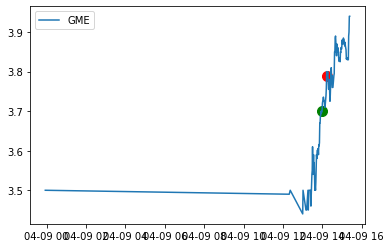

MG analysis for run 228 with profit 29.4


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-854.56,-854.56,buy,2020-04-09 14:31:22.557310,4.36,"[3.31, 3.66, 3.96, 4.23]",[4.54],196,"{'rsi': 71.9752329502704, 'macd': [0.04549394640780324, 0.045712012475004116, 0.053339135319961706, 0.06748187674755002, 0.07699562713386499], 'sell_macd': [0.023193809141702992, 0.02347546845497206, 0.028584872225636992, 0.03790927942062705, 0.044163242437234906], 'slow macd': [0.06795719543152323, 0.06814607137592876, 0.06981021342413873, 0.07298892194042628, 0.07563676384694995], 'macd_signal': [0.06827044470697195, 0.06375875826057839, 0.061674833672455055, 0.06283624228747405, 0.06566811925675223], 'sell_macd_signal': [0.03810917967723104, 0.03518243743277925, 0.033862924391350795, 0.03467219539720605, 0.03657040480521182]}",5.26,4.06
1,29.40,883.96,sell,2020-04-09 14:40:02.894004,4.51,None,None,196,"{'rsi': 78.09048509379478, 'reasons': 'rsi max', 'movement': 0.03440366972477052, 'sell_macd': [0.02347546845497206, 0.028584872225636992, 0.03790927942062705, 0.044163242437234906, 0.05625511956138052], 'sell_macd_signal': [0.03518243743277925, 0.033862924391350795, 0.03467219539720605, 0.03657040480521182, 0.04050734775644556]}",5.26,4.06


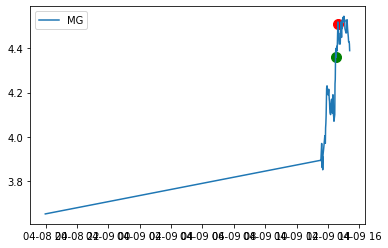

PVG analysis for run 228 with profit -28.1


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2068.16,-2068.16,buy,2020-04-09 14:36:24.858350,7.36,"[6.5, 7.0, 7.28]",[7.37],281,"{'rsi': 68.7209326715907, 'macd': [-0.007118483882480042, -0.004721233853548057, -0.0027892432741447593, 0.0035425355931835156, 0.011653843416952192], 'sell_macd': [-0.005700635981098934, -0.003992006940264581, -0.0026087634416889216, 0.001619851796704097, 0.006971761699390733], 'slow macd': [0.040325459248157, 0.03947970080623975, 0.03863843372184217, 0.03876226047270759, 0.03945393432790567], 'macd_signal': [-0.009926693461620926, -0.008885601540006352, -0.007666329886834034, -0.005424556790830524, -0.0020088767492739807], 'sell_macd_signal': [-0.008470558995376399, -0.007574848584354035, -0.006581631555821013, -0.004941334885315991, -0.002558715568374646]}",7.99,7.15
1,-28.10,2040.06,sell,2020-04-09 14:46:27.569078,7.26,None,None,281,"{'rsi': 44.37448334114585, 'reasons': 'below cost & macd negative', 'movement': -0.015625000000000028, 'sell_macd': [0.009555841863031489, 0.006406240127035723, 0.003349326564869415, 0.001443298768832868, -0.0003204020952072284], 'sell_macd_signal': [0.00812767460482834, 0.007783387709269817, 0.006896575480389736, 0.005805920138078362, 0.004580655691421244]}",7.99,7.15


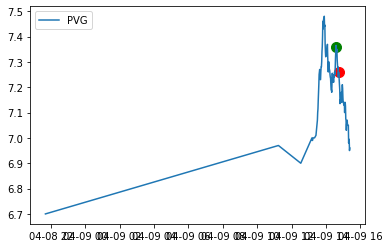

VICI analysis for run 228 with profit -35.64


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1780.02,-1780.02,buy,2020-04-09 14:39:45.545015,17.98,"[14.48, 15.77, 17.67]",[18.04],99,"{'rsi': 65.79777008843756, 'macd': [0.024083178215004608, 0.03133485189750118, 0.03306952669834473, 0.04721413485629, 0.06573524797313013], 'sell_macd': [0.003499887451965833, 0.008959092388451495, 0.010759004126121852, 0.020593233997995952, 0.03318363085922016], 'slow macd': [0.20196674081633503, 0.1993914734413913, 0.19598353416769498, 0.19517361717231552, 0.1957156749591782], 'macd_signal': [0.05019523965666454, 0.04642316210483187, 0.043752435023534444, 0.044444774990085555, 0.04870286958669447], 'sell_macd_signal': [0.01754380595927333, 0.015826863245108964, 0.014813291421311542, 0.015969279936648425, 0.01941215012116277]}",19.78,17.38
1,-35.64,1744.38,sell,2020-04-09 14:50:32.862382,17.62,None,None,99,"{'rsi': 46.11253364529473, 'reasons': 'below cost & macd negative', 'movement': -0.01946607341490553, 'sell_macd': [0.010626920233548276, 0.008437285134895944, 0.006621500835493066, 0.003821909162770254, -0.0010066286232834898], 'sell_macd_signal': [0.02341798519615418, 0.020421845183902533, 0.01766177631422064, 0.014893802883930562, 0.011713716582487751]}",19.78,17.38


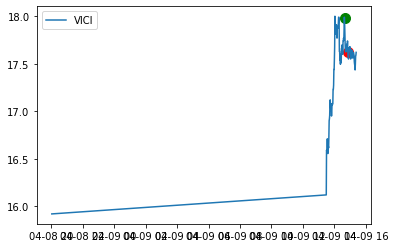

ESI analysis for run 228 with profit -42.96


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4833.00,-4833.00,buy,2020-04-09 14:43:32.639534,9.00,"[7.71, 8.15, 8.95]",[9.03],537,"{'rsi': 65.23128138032787, 'macd': [0.021777273824673316, 0.025640192085283786, 0.029969940670261153, 0.033020656049712827, 0.035034513899145026], 'sell_macd': [0.011061697619473065, 0.013687828491832477, 0.01659536126910055, 0.018645447053089015, 0.02000076783212812], 'slow macd': [0.06156418413221587, 0.061584659488476134, 0.06182487346560528, 0.0619469977628917, 0.061960280456617056], 'macd_signal': [0.02376096013909185, 0.024136806528330237, 0.02530343335671642, 0.0268468778953157, 0.028484405096081567], 'sell_macd_signal': [0.011732070457306464, 0.012123222064211667, 0.013017649905189443, 0.014143209334769358, 0.01531472103424111]}",9.33,8.89
1,-42.96,4790.04,sell,2020-04-09 15:03:36.546319,8.92,None,None,537,"{'rsi': 38.62325930751436, 'reasons': 'below cost & macd negative', 'movement': -0.00777777777777781, 'sell_macd': [0.011629520735706222, 0.008688534756144506, 0.006024278996015653, 0.0033505176375268064, -0.00033488754619881433], 'sell_macd_signal': [0.018383947843237373, 0.0164448652258188, 0.01436074797985817, 0.012158701911391897, 0.009659984019873755]}",9.33,8.89


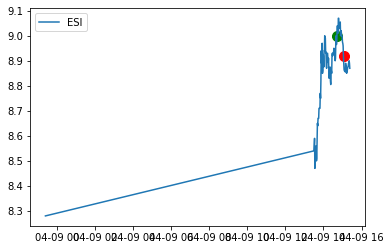

CIM analysis for run 228 with profit -10.16


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1008.38,-1008.38,buy,2020-04-09 14:41:41.658404,7.94,"[6.86, 7.86]",[8.16],127,"{'rsi': 64.00565910465653, 'macd': [0.020100786460696796, 0.026035255146704017, 0.030372115169680747, 0.03798678196637617, 0.04415796783881376], 'sell_macd': [0.0132832492885262, 0.017107033371119407, 0.019854046508579692, 0.02470816003765819, 0.028585285384502335], 'slow macd': [0.04698853737964104, 0.047518600696196955, 0.04792707782079031, 0.04914107124438427, 0.05030733857053882], 'macd_signal': [-0.007419543914282515, -0.0007285841020852092, 0.005491555752267983, 0.011990600995089622, 0.01842407436383445], 'sell_macd_signal': [-0.005374051658838119, -0.0008778346528466137, 0.003268541579438648, 0.007556465271082556, 0.01176222929376651]}",9.37,7.51
1,-10.16,998.22,sell,2020-04-09 15:15:39.861535,7.86,None,None,127,"{'rsi': 42.83536446911007, 'reasons': 'below cost & macd negative', 'movement': -0.014420062695924682, 'sell_macd': [0.0044132112866224205, 0.0052414548373578285, 0.0037408465023807125, 0.0025229588841861883, -1.725171290356542e-05], 'sell_macd_signal': [0.004646748776038982, 0.004765689988302751, 0.004560721291118343, 0.004153168809731912, 0.0033190847052048168]}",9.37,7.51


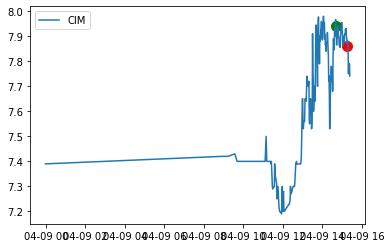

ARLP analysis for run 228 with profit -23.0


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-765.9,-765.9,buy,2020-04-09 14:01:49.364620,3.33,[3.12],[3.37],230,"{'rsi': 74.39270584796267, 'macd': [0.048243817444124204, 0.05274870479781324, 0.05571693614560003, 0.05992034319989914, 0.06316893455925143], 'sell_macd': [0.02929563750367592, 0.032119371175173494, 0.03392852246237732, 0.036533984212634874, 0.03850533123604816], 'slow macd': [0.02495007507473579, 0.02700252531926317, 0.028855655231850186, 0.031018241920348633, 0.03308623032600799], 'macd_signal': [0.038930698973728015, 0.04169430013854506, 0.044498827339956054, 0.04758313051194467, 0.05070029132140602], 'sell_macd_signal': [0.023581817882904428, 0.025289328541358243, 0.027017167325562058, 0.02892053070297662, 0.030837490809590928]}",4.11,3.07
1,-23.0,742.9,sell,2020-04-09 14:52:13.186235,3.23,None,None,230,"{'rsi': 38.24417840861231, 'reasons': 'below cost & macd negative', 'movement': -0.024024024024024045, 'sell_macd': [0.00691319775245125, 0.005673731726145714, 0.004660203241672267, 0.002308619964917824, -0.0011693490814481677], 'sell_macd_signal': [0.006330130829876267, 0.006198851009130157, 0.005891121455638579, 0.005174621157494428, 0.003905827109705909]}",4.11,3.07


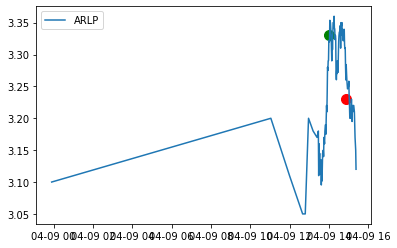

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


MRCC analysis for run 228 with profit -80.85


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5813.85,-5813.85,buy,2020-04-09 14:50:56.188822,7.91,"[6.0, 6.37, 6.87, 7.22, 7.87]",[7.96],735,"{'rsi': 70.8867670175381, 'macd': [0.08942168327535871, 0.10203402008979001, 0.11075269970121315, 0.11313055182182907, 0.11609746671038224], 'sell_macd': [0.050463025403278294, 0.05868645985212506, 0.06433216903496586, 0.06581801815100974, 0.06767948475895302], 'slow macd': [0.07277714392954682, 0.0769621187326095, 0.08068933926316468, 0.08334970594999191, 0.08614383026930028], 'macd_signal': [0.0962225997385623, 0.09738488380880785, 0.10005844698728891, 0.10267286795419694, 0.105357787705434], 'sell_macd_signal': [0.055388668985901134, 0.05604822715914592, 0.05770501553430991, 0.05932761605764987, 0.060997989797910504]}",8.16,7.84
1,-80.85,5733.00,sell,2020-04-09 15:00:50.661066,7.80,None,None,735,"{'rsi': 59.38984459773019, 'reasons': 'stopped', 'movement': -0.012626262626262581, 'sell_macd': [0.06767948475895302, 0.06669258231372766, 0.06401846894973762, 0.060064374523904895, 0.05464476361385451], 'sell_macd_signal': [0.060997989797910504, 0.062136908301073934, 0.06251322043080668, 0.06202345124942632, 0.060547713722311956]}",8.16,7.84


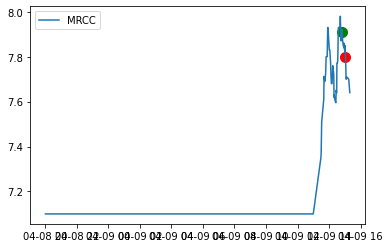

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


OSW analysis for run 228 with profit -70.68


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1517.76,-1517.76,buy,2020-04-09 14:16:55.642762,4.08,"[2.59, 2.68, 2.8, 2.83, 3.16, 3.5, 3.59, 3.73, 4.02]",[],372,"{'rsi': 71.29511874518944, 'macd': [0.04523667095429795, 0.04604125873702403, 0.05013555105982048, 0.052771984633979585, 0.0566293387489587], 'sell_macd': [0.025440420327075497, 0.025966435504829022, 0.028636493623794834, 0.030345155877225416, 0.03284092963473961], 'slow macd': [0.039437991025240926, 0.040373130162357995, 0.0419685970291539, 0.04336935467504777, 0.04506854137017058], 'macd_signal': [0.05287705533189243, 0.05150989601291875, 0.051235027022299096, 0.05154241854463519, 0.052559802585499894], 'sell_macd_signal': [0.03070812220233441, 0.029759784862833333, 0.029535126615025633, 0.029697132467465588, 0.030325891900920394]}",4.56,3.92
1,-70.68,1447.08,sell,2020-04-09 14:22:39.878537,3.89,None,None,372,"{'rsi': 43.257909496807265, 'reasons': 'stopped', 'movement': -0.040441176470588244, 'sell_macd': [0.03758884595268919, 0.035099033589996775, 0.031071919624392486, 0.027010896798929984, 0.01908008814533657], 'sell_macd_signal': [0.03267315990882269, 0.033158334645057505, 0.0327410516409245, 0.0315950206725256, 0.029092034167087794]}",4.56,3.92


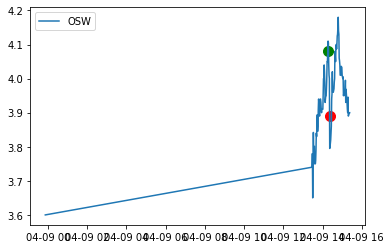

NOVA analysis for run 228 with profit -83.3


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5958.4,-5958.4,buy,2020-04-09 14:50:53.485561,12.16,"[9.32, 10.11, 10.41, 10.78, 11.11, 12.0]",[12.2],490,"{'rsi': 62.51909593507969, 'macd': [0.06591213685082309, 0.06946822576024125, 0.07265925580881216, 0.07433132486898941, 0.07878287384925287], 'sell_macd': [0.0374573113997414, 0.039861930092563114, 0.04199719231953303, 0.043115614933801893, 0.046024572621105264], 'slow macd': [0.09725990596439082, 0.09792532461477066, 0.09862081722415539, 0.09910296245618078, 0.10018773028067685], 'macd_signal': [0.04558548387012569, 0.0503620322481488, 0.05482147696028147, 0.058723446542023064, 0.06273533200346902], 'sell_macd_signal': [0.02317968017576208, 0.026516130159122287, 0.029612342591204436, 0.03231299705972393, 0.0350553121720002]}",12.52,12.04
1,-83.3,5875.1,sell,2020-04-09 14:52:09.500174,11.99,None,None,490,"{'rsi': 54.09765113590396, 'reasons': 'stopped', 'movement': -0.00986842105263166, 'sell_macd': [0.04199719231953303, 0.043115614933801893, 0.04550509210162268, 0.04158124194535873, 0.037464199720407265], 'sell_macd_signal': [0.029612342591204436, 0.03231299705972393, 0.03495141606810368, 0.03627738124355469, 0.0365147449389252]}",12.52,12.04


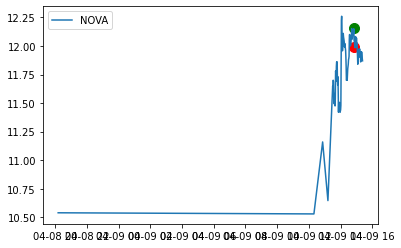

EVOP analysis for run 228 with profit -29.23


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1211.86,-1211.86,buy,2020-04-09 14:19:03.796950,15.34,"[12.58, 13.8, 14.96]",[],79,"{'rsi': 61.80047950659046, 'macd': [0.12364368226872458, 0.1524481882811628, 0.17088535751277512, 0.18258530084224134, 0.1851321476007417], 'sell_macd': [0.07182616948031928, 0.09044534970559859, 0.10222074533950831, 0.10954935563424861, 0.11088139799853813], 'slow macd': [0.09815287038632015, 0.10610940326901641, 0.11278015278921139, 0.11857714360680838, 0.12281087703218319], 'macd_signal': [0.13052084656157376, 0.13490631490549157, 0.14210212342694828, 0.1501987589100069, 0.15718543664815385], 'sell_macd_signal': [0.07760164696784225, 0.08017038751539352, 0.08458045908021647, 0.0895742383910229, 0.09383567031252595]}",17.57,14.6
1,-29.23,1182.63,sell,2020-04-09 14:43:52.280539,14.97,None,None,79,"{'rsi': 47.295582159843086, 'reasons': 'below cost & macd negative', 'movement': -0.02301360220555165, 'sell_macd': [0.01876957478657104, 0.013701411854317058, 0.008535292532373617, 0.00387941653433721, -0.0003184013412020903], 'sell_macd_signal': [0.04113436855830238, 0.03564777721750532, 0.030225280280478977, 0.024956107531250625, 0.019901205756760083]}",17.57,14.6


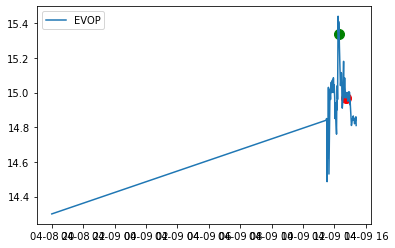

EVH analysis for run 228 with profit -54.6


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1195.35,-1195.35,buy,2020-04-09 14:06:15.651718,6.13,"[4.7, 4.84, 5.01, 5.15, 5.53, 6.04]",[6.15],195,"{'rsi': 70.76209310609867, 'macd': [0.09614507190530741, 0.10621097352067821, 0.11528014460371061, 0.12346504907498979, 0.12607755201886928], 'sell_macd': [0.05900551233748441, 0.0652849005715277, 0.07088851607115121, 0.07589278118681708, 0.0772481464563386], 'slow macd': [0.047218044379403246, 0.05155266627314603, 0.05593801385907593, 0.06036301695375279, 0.06385781105732669], 'macd_signal': [0.07994770118021462, 0.08520035564830733, 0.09121631343938799, 0.09766606056650835, 0.10334835885698054], 'sell_macd_signal': [0.04946899988012728, 0.05263218001840737, 0.05628344722895613, 0.060205314020528325, 0.06361388050769037]}",7.05,5.82
1,-54.60,1140.75,sell,2020-04-09 14:23:22.250267,5.85,None,None,195,"{'rsi': 41.91722088444044, 'reasons': 'below cost & macd negative', 'movement': -0.042414355628058696, 'sell_macd': [0.019055069885486553, 0.014098895647962628, 0.00952916383108704, 0.005330292755196808, -0.0011276625345262303], 'sell_macd_signal': [0.04062064611138437, 0.035316296018700025, 0.030158869581177427, 0.025193154215981305, 0.0199289908658798]}",7.05,5.82


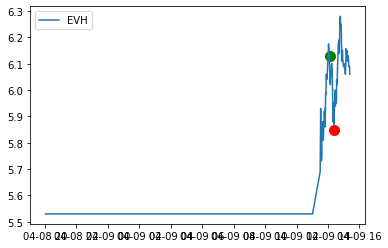

AGS analysis for run 228 with profit -24.5


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-583.1,-583.1,buy,2020-04-09 14:43:45.574810,2.38,"[1.33, 1.37, 1.39, 1.57, 1.73, 1.87, 2.04, 2.2, 2.26]",[],245,"{'rsi': 71.77990319020317, 'macd': [0.025694019766419718, 0.027252952609686076, 0.02856262418079547, 0.03285296374014557, 0.039030831329492255], 'sell_macd': [0.013986568068342642, 0.015078515379469692, 0.015993298798796296, 0.018836074206079356, 0.022884521611675535], 'slow macd': [0.05581239689661066, 0.05564274746494924, 0.055477639775180165, 0.055956718802265826, 0.05694773598184], 'macd_signal': [0.020677120801502157, 0.02199228716313894, 0.023306354566670247, 0.025215676401365312, 0.027978707386990702], 'sell_macd_signal': [0.010129943231330834, 0.011119657660958605, 0.012094385888526144, 0.013442723552036786, 0.015331083163964535]}",3.1,2.14
1,-24.5,558.6,sell,2020-04-09 15:02:41.890197,2.28,None,None,245,"{'rsi': 47.0292631941129, 'reasons': 'below cost & macd negative', 'movement': -0.06172839506172854, 'sell_macd': [0.0036650480557347542, 0.0031965708368493218, 0.0015432564995769837, 0.0009621900484608759, -0.0005420460179728082], 'sell_macd_signal': [0.0151128858224083, 0.012729622825296504, 0.0104923495601526, 0.008586317657814254, 0.006760644922656841]}",3.1,2.14


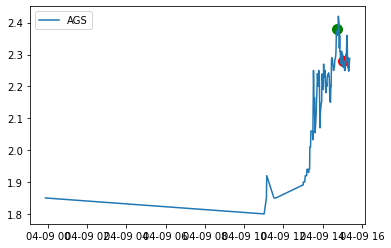

WTI analysis for run 228 with profit -27.2


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-680.0,-680.0,buy,2020-04-09 14:38:13.746242,2.5,"[1.54, 1.56, 1.69, 1.87, 2.13, 2.38, 2.49]",[2.51],272,"{'rsi': 69.05557368143309, 'macd': [0.032478618622934885, 0.036546856497399194, 0.03852799037058441, 0.0404308389564636, 0.04207516945586809], 'sell_macd': [0.019908126963266604, 0.022492404854661974, 0.023699733018675673, 0.024847005185197002, 0.02581829511774414], 'slow macd': [0.03426069740763138, 0.03532989692065591, 0.03609875277502894, 0.03690672650945981, 0.0377142117781073], 'macd_signal': [0.02027771773308115, 0.023531545485944758, 0.026530834462872688, 0.02931083536159087, 0.03186370218044631], 'sell_macd_signal': [0.011920134242951283, 0.014034588365293421, 0.01596761729596987, 0.017743494873815296, 0.019358454922601066]}",3.16,2.29
1,-27.2,652.8,sell,2020-04-09 14:52:30.697165,2.4,None,None,272,"{'rsi': 44.881586684752115, 'reasons': 'below cost & macd negative', 'movement': -0.04095386210471748, 'sell_macd': [0.00894809023884724, 0.005935902378872537, 0.0029973676518939563, 0.0017076345185094155, -9.875018956329029e-05], 'sell_macd_signal': [0.013490983776401773, 0.011979967496895925, 0.010183447527895531, 0.008488284926018308, 0.006770877902901988]}",3.16,2.29


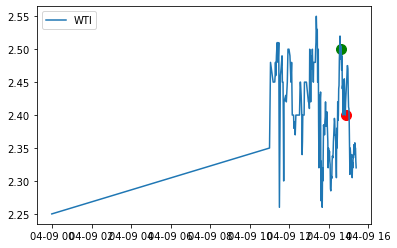

DAN analysis for run 228 with profit -44.08


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1507.84,-1507.84,buy,2020-04-09 14:46:50.461133,9.92,"[6.54, 6.66, 6.89, 7.3, 7.87, 8.34, 8.85, 9.85]",[9.99],152,"{'rsi': 64.24801919986596, 'macd': [0.04423281660373668, 0.04621672744867844, 0.04567287722806235, 0.04711945751415492, 0.05090672745324021], 'sell_macd': [0.025135022507239313, 0.026531608329136702, 0.026251914056210524, 0.027251478076575353, 0.029754365909633762], 'slow macd': [0.09572079106616549, 0.09521906855121642, 0.09429010422450723, 0.09376443156051018, 0.09377057689193613], 'macd_signal': [0.020311037904068137, 0.0254921758129902, 0.029528316096004627, 0.03304654437963468, 0.03661858099435579], 'sell_macd_signal': [0.008159823196423752, 0.011834180222966343, 0.014717726989615178, 0.017224477207007212, 0.019730454947532523]}",11.14,9.58
1,-44.08,1463.76,sell,2020-04-09 14:52:11.800571,9.63,None,None,152,"{'rsi': 37.697252390763765, 'reasons': 'below cost & macd negative', 'movement': -0.02958876629889668, 'sell_macd': [0.02612344258591648, 0.017240600481903456, 0.010095001433557016, 0.0002400541045393112, -0.007701983477870655], 'sell_macd_signal': [0.021009052475209313, 0.020255362076548142, 0.018223289947949917, 0.014626642779267795, 0.010160917527840103]}",11.14,9.58


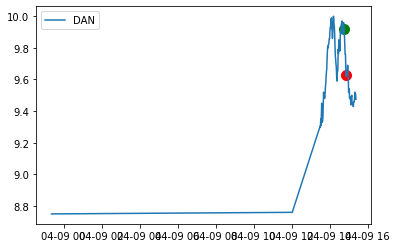

NUGT analysis for run 228 with profit -29.55


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1926.66,-1926.66,buy,2020-04-09 14:36:24.718566,9.78,"[7.34, 7.5, 8.32, 9.64, 9.75]",[9.85],197,"{'rsi': 69.443381945484, 'macd': [0.008288852062820595, 0.012988278727091185, 0.017311894732124244, 0.02529635861376356, 0.03605003990434952], 'sell_macd': [0.0006100268328204095, 0.004000364416945956, 0.00710451884071972, 0.012553151913261118, 0.019752695191693093], 'slow macd': [0.10554963053159305, 0.10412342619442327, 0.10280307837970781, 0.1023851125119819, 0.10279643601790589], 'macd_signal': [0.01118231050450909, 0.011543504149025509, 0.012697182265645255, 0.015217017535268915, 0.019383622009085034], 'sell_macd_signal': [0.0007730981925637494, 0.001418551437440191, 0.002555744918096097, 0.0045552263171291015, 0.007594720092041899]}",10.68,9.48
1,-29.55,1897.11,sell,2020-04-09 14:52:10.477321,9.63,None,None,197,"{'rsi': 44.4359986855722, 'reasons': 'below cost & macd negative', 'movement': -0.014212678936605251, 'sell_macd': [0.016705633878068227, 0.009150908611589514, 0.005742669331064931, 0.0019733573029814266, -0.0014569294371238328], 'sell_macd_signal': [0.024562866687258204, 0.021480475072124465, 0.018332913923912557, 0.015061002599726332, 0.011757416192356299]}",10.68,9.48


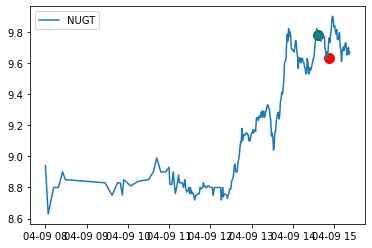

AMRS analysis for run 228 with profit -13.77


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1193.40,-1193.40,buy,2020-04-09 13:57:31.098058,2.60,"[2.23, 2.32, 2.49]","[2.62, 2.73]",459,"{'rsi': 73.1052804955479, 'macd': [0.025551801084490844, 0.026058609807484867, 0.027754159549916224, 0.02916515539313247, 0.029938270023651015], 'sell_macd': [0.016537923509710062, 0.01674330890862219, 0.017724864947922025, 0.01851926101818302, 0.01889776105970853], 'slow macd': [0.000547554065450484, 0.0015457964851877115, 0.002781611208048318, 0.003994119497720661, 0.0051032778729886985], 'macd_signal': [0.016591488104754915, 0.018484912445300906, 0.02033876186622397, 0.02210404057160567, 0.02367088646201474], 'sell_macd_signal': [0.011068963515218085, 0.012203832593898905, 0.01330803906470353, 0.014350283455399428, 0.015259778976261249]}",3.0,2.47
1,-13.77,1179.63,sell,2020-04-09 14:22:53.786933,2.57,None,None,459,"{'rsi': 47.26128138275341, 'reasons': 'below cost & macd negative', 'movement': -0.013435700575815794, 'sell_macd': [0.0027835442867485405, 0.001176054720967823, 0.0004276725304768192, 0.0003584439076202983, -0.00021963610898989572], 'sell_macd_signal': [0.005487555301391878, 0.004625255185307067, 0.003785738654341018, 0.003100279704996874, 0.0024362965421995198]}",3.0,2.47


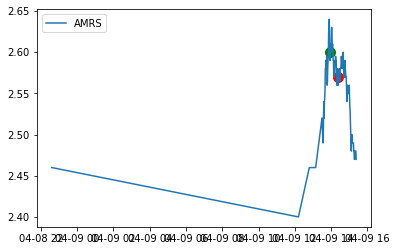

EPRT analysis for run 228 with profit -774.4


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1182.72,-1182.72,buy,2020-04-09 14:00:44.495230,13.44,"[9.88, 10.78, 11.83, 13.36]",[13.7],88,"{'rsi': 78.5947402405927, 'macd': [0.3394357611488399, 0.34984470960911374, 0.3540289887775998, 0.37441235292638453, 0.3853176968842469], 'sell_macd': [0.2124316085438771, 0.2179765674659393, 0.2194768397757798, 0.2315617683318152, 0.23745181956597428], 'slow macd': [0.12370688363226101, 0.1348919562564994, 0.14497003873684378, 0.15824864234832958, 0.17005234980160466], 'macd_signal': [0.2656955022851991, 0.28252534374998206, 0.2968260727555056, 0.3123433287896814, 0.3269382024085945], 'sell_macd_signal': [0.16853773587695248, 0.17842550219474984, 0.18663576971095583, 0.1956209694351277, 0.203987139461297]}",15.47,12.78
1,-774.40,408.32,sell,2020-04-09 15:12:52.495635,14.08,None,None,29,"{'rsi': 73.84947010504847, 'reasons': 'scale-out', 'movement': 0.024000000000000004, 'sell_macd': [0.04429031616956891, 0.049140853091136805, 0.050464117535330644, 0.05733336103034681, 0.06843493568840664], 'sell_macd_signal': [0.04572942716242491, 0.04641171234816729, 0.04722219338559996, 0.049244426914549326, 0.05308252866932079]}",15.47,12.78


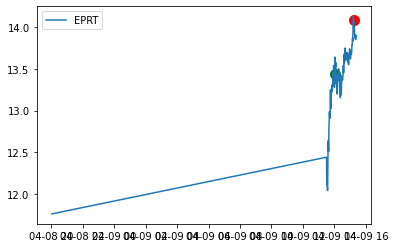

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


ANF analysis for run 228 with profit -22.77


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2359.80,-2359.80,buy,2020-04-09 14:31:04.845717,11.40,"[7.52, 7.92, 8.82, 9.34, 10.48, 11.33]",[11.48],207,"{'rsi': 61.49793299275751, 'macd': [-0.0009633888107831723, 0.005667879869783121, 0.011596447868861048, 0.01770462567020381, 0.02547935613370278], 'sell_macd': [-0.005516138137524607, -0.0008350321439838382, 0.0033429080086975205, 0.007593992439245412, 0.012885824561241321], 'slow macd': [0.07564483182849457, 0.07514523221080083, 0.07472533630950018, 0.07453937796718435, 0.07488881912770573], 'macd_signal': [0.00996145367586099, 0.009102738914645418, 0.009601480705488543, 0.011222109698431596, 0.014073558985485833], 'sell_macd_signal': [8.138456068038438e-05, -0.00010189878025246014, 0.000587062577537536, 0.0019884485498791113, 0.004167923752151553]}",12.26,11.12
1,-22.77,2337.03,sell,2020-04-09 14:53:15.922920,11.29,None,None,207,"{'rsi': 44.02140607555853, 'reasons': 'below cost & macd negative', 'movement': -0.007894736842105251, 'sell_macd': [0.0180621497263882, 0.01190217518341008, 0.007467101835851864, 0.0018363030996262353, -0.0015362193324932605], 'sell_macd_signal': [0.023612403096736366, 0.02127035751407111, 0.01850970637842726, 0.015175025722667055, 0.011832776711634992]}",12.26,11.12


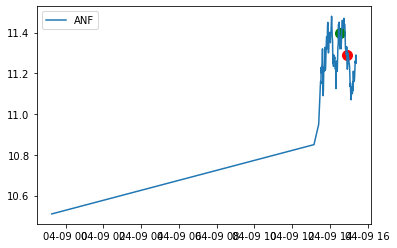

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


ADNT analysis for run 228 with profit -17.1


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1187.5,-1187.5,buy,2020-04-09 14:42:29.933815,12.50,"[7.22, 7.42, 7.61, 7.83, 8.12, 8.82, 9.05, 9.88, 10.67, 12.39]",[12.63],95,"{'rsi': 63.0377266309325, 'macd': [0.030826354311292548, 0.055322802300434404, 0.07388471679562336, 0.08838325702067884, 0.09315124999449154], 'sell_macd': [0.014564850944129404, 0.030860548842927216, 0.04315770890896431, 0.05269890235121544, 0.05581283357438238], 'slow macd': [0.1474939982058796, 0.14967470648629266, 0.1514416440821691, 0.15298500946872728, 0.1530407246692853], 'macd_signal': [0.005973067846234116, 0.015843014737074175, 0.027451355148784013, 0.03963773552316298, 0.05034043841742869], 'sell_macd_signal': [-0.004256578699270345, 0.0027668468091691673, 0.010845019229128196, 0.019215795853545645, 0.02653520339771299]}",14.36,11.88
1,-17.1,1170.4,sell,2020-04-09 15:06:04.974920,12.32,None,None,95,"{'rsi': 45.34060418097216, 'reasons': 'below cost & macd negative', 'movement': -0.01519999999999996, 'sell_macd': [0.009662270588250976, 0.010026638351702033, 0.008621903643330597, 0.0037789687583220655, -4.382425283111502e-05], 'sell_macd_signal': [0.012832316256782442, 0.01227118067576636, 0.011541325269279208, 0.00998885396708778, 0.007982318323104]}",14.36,11.88


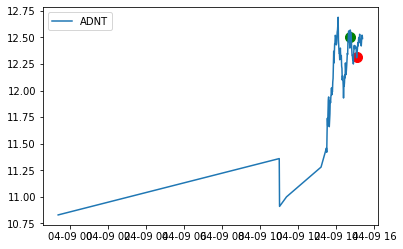

X analysis for run 228 with profit -17.85


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2545.41,-2545.41,buy,2020-04-09 14:36:24.534077,7.13,"[6.4, 7.07]",[7.17],357,"{'rsi': 61.37471108315392, 'macd': [0.00786580556782912, 0.011670713948615408, 0.015707371922752067, 0.018292133903369034, 0.020108774954811004], 'sell_macd': [0.004627436231208648, 0.007138863393572059, 0.009777133086406486, 0.011446211638141968, 0.012598140228609722], 'slow macd': [0.022379661098778314, 0.022817270036961546, 0.023421695901260975, 0.023860359287964705, 0.02422578232501227], 'macd_signal': [-0.004080830351274673, -0.0009305214912966567, 0.002397057191513088, 0.0055760725338842776, 0.008482613018069622], 'sell_macd_signal': [-0.003710666795545418, -0.0015407607577219225, 0.0007228180111037595, 0.002867496736511401, 0.004813625434931065]}",7.65,6.99
1,-17.85,2527.56,sell,2020-04-09 14:52:12.732859,7.08,None,None,357,"{'rsi': 38.94463561751601, 'reasons': 'below cost & macd negative', 'movement': -0.008391608391608461, 'sell_macd': [0.013172037497242606, 0.009564272257938988, 0.006369075029158289, 0.003017374915443405, -0.00015300666557394038], 'sell_macd_signal': [0.01426662220437782, 0.013326152215090054, 0.011934736777903701, 0.010151264405411642, 0.008090410191214526]}",7.65,6.99


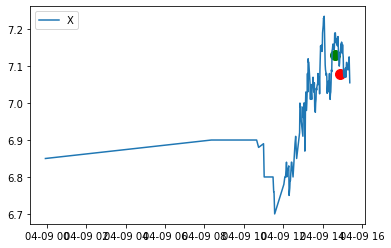

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


SFIX analysis for run 228 with profit -41.82


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1872.06,-1872.06,buy,2020-04-09 14:46:41.409350,15.22,"[11.55, 11.99, 12.42, 12.75, 13.54]",[15.27],123,"{'rsi': 59.89802394776861, 'macd': [0.06654138215924021, 0.06003914866260196, 0.05904692414343948, 0.05998980323362879, 0.06483120647256868], 'sell_macd': [0.04106605478737535, 0.03669739791335935, 0.03593354323343334, 0.03643010396032764, 0.03946079928050317], 'slow macd': [0.11229157690285163, 0.11029127501423552, 0.10923415396435132, 0.10856667209644044, 0.10873854636015601], 'macd_signal': [0.03917622290753435, 0.04334880805854787, 0.046488431275526196, 0.04918870566714671, 0.05231720582823111], 'sell_macd_signal': [0.022829485403644958, 0.025603067905587838, 0.027669162971156937, 0.029421351168991076, 0.03142924079129349]}",16.66,14.74
1,-41.82,1830.24,sell,2020-04-09 14:52:11.075050,14.88,None,None,123,"{'rsi': 40.12575672256518, 'reasons': 'below cost & macd negative', 'movement': -0.022339027595269373, 'sell_macd': [0.04018670412105507, 0.034065548737256535, 0.024957303649397744, 0.011561823014060835, -6.532842924045212e-05], 'sell_macd_signal': [0.034715370154621124, 0.03458540587114821, 0.032659785426798114, 0.02844019294425066, 0.02273908866955244]}",16.66,14.74


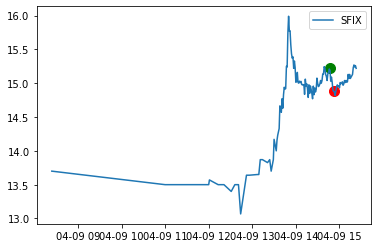

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


HBAN analysis for run 228 with profit -23.85


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1504.14,-1504.14,buy,2020-04-09 13:51:26.234511,9.46,"[6.88, 7.37, 7.97, 8.19, 8.46, 8.73, 9.11, 9.44]",[9.54],159,"{'rsi': 69.12659399746637, 'macd': [0.12456257806822535, 0.13384172513971393, 0.14197961272974347, 0.14713630969936986, 0.14790424824025372], 'sell_macd': [0.07577924710953532, 0.08149867996178628, 0.0864553980289724, 0.08945471862640275, 0.0895911409279524], 'slow macd': [0.06641741999197848, 0.0711800926230115, 0.07592786925376416, 0.08025450761855701, 0.08378692539021415], 'macd_signal': [0.10977562733903758, 0.11458884689917284, 0.12006700006528696, 0.12548086199210354, 0.12996553924173357], 'sell_macd_signal': [0.06742927594111696, 0.07024315674525082, 0.07348560500199514, 0.07667942772687666, 0.07926177036709181]}",10.59,9.09
1,-23.85,1480.29,sell,2020-04-09 14:23:06.443103,9.31,None,None,159,"{'rsi': 36.127869106350616, 'reasons': 'below cost & macd negative', 'movement': -0.016376122556788098, 'sell_macd': [0.017708346839979683, 0.013478043499381087, 0.008188481889831678, 0.0003240380136908527, -0.006068048617246191], 'sell_macd_signal': [0.02521367868953811, 0.022866551651506705, 0.0199309376991717, 0.01600955776207553, 0.011594036486211184]}",10.59,9.09


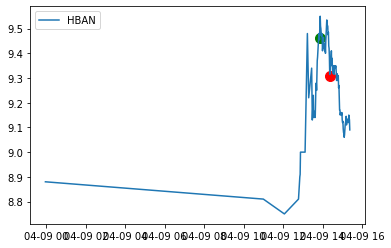

NMFC analysis for run 228 with profit -1.84


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1383.68,-1383.68,buy,2020-04-09 14:36:24.410971,7.52,"[5.0, 5.19, 5.54, 5.83, 6.63, 6.81]","[7.56, 7.67]",184,"{'rsi': 64.29617528397, 'macd': [0.016816158265432257, 0.018196216906702034, 0.017873513940099173, 0.026191925986890574, 0.03679818128295942], 'sell_macd': [0.004642816974446795, 0.00590591036418342, 0.006034218065742003, 0.0117701173388296, 0.018943933430342064], 'slow macd': [0.08954513949390819, 0.08832404900338098, 0.08681944068082359, 0.08705559361447879, 0.08801327675157733], 'macd_signal': [0.026426537966907394, 0.024780473754866323, 0.02339908179191289, 0.023957650630908427, 0.026525756761318624], 'sell_macd_signal': [0.009402348327514675, 0.008703060734848424, 0.00816929220102714, 0.008889457228587631, 0.010900352468938519]}",8.5,7.21
1,-1.84,1381.84,sell,2020-04-09 15:14:39.870629,7.51,None,None,184,"{'rsi': 37.641644193749784, 'reasons': 'below cost & macd negative', 'movement': -0.0006635700066356859, 'sell_macd': [0.01042830083827262, 0.008048861728066292, 0.005025287593774408, 0.0026039923255760655, -0.00139447142010507], 'sell_macd_signal': [0.018898030481562605, 0.016728196730863343, 0.014387614903445556, 0.012030890387871657, 0.009345818026276312]}",8.5,7.21


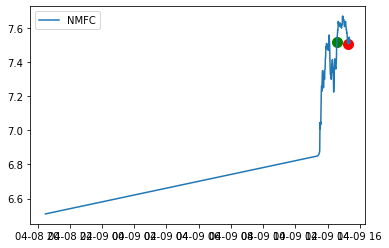

ORBC analysis for run 228 with profit -71.28


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2225.52,-2225.52,buy,2020-04-09 14:46:30.276637,2.81,"[1.85, 1.91, 1.96, 2.0, 2.15, 2.42]",[],792,"{'rsi': 67.19769272427548, 'macd': [0.00470799879521433, 0.005696882736907494, 0.006406727617300767, 0.008485304345617006, 0.01320800344221107], 'sell_macd': [0.002508536987940957, 0.003190147324958481, 0.0036798417781542803, 0.005052592757551988, 0.008134572835555964], 'slow macd': [0.019386293514007225, 0.0192398285680353, 0.019074304715594792, 0.019211382843012714, 0.01994651728516228], 'macd_signal': [-0.0011299577513068134, 0.00023541034633604808, 0.001469673800528992, 0.002872799909546595, 0.00493984061607949], 'sell_macd_signal': [-0.0016991998101518713, -0.000721330383129801, 0.00015890404912701547, 0.00113764179081201, 0.002537027999760801]}",3.03,2.74
1,-71.28,2154.24,sell,2020-04-09 15:03:39.762681,2.72,None,None,792,"{'rsi': 40.78672822392002, 'reasons': 'stopped', 'movement': -0.02846975088967974, 'sell_macd': [0.00646925364218065, 0.004545031626023377, 0.0024671309429655786, 0.0010756871517130229, -0.000801745505778495], 'sell_macd_signal': [0.008064527273646666, 0.007360628144122009, 0.006381928703890723, 0.005320680393455183, 0.004096195213608447]}",3.03,2.74


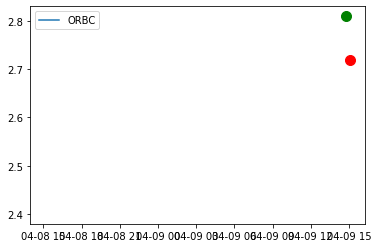

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


SHO analysis for run 228 with profit -28.92


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2270.22,-2270.22,buy,2020-04-09 14:30:42.104706,9.42,"[8.23, 8.96]",[],241,"{'rsi': 60.98363320151176, 'macd': [-0.01985885457554737, -0.011215182531241652, -0.005910708051727553, -0.0020862826555081426, 0.006517882913103179], 'sell_macd': [-0.01685664524097774, -0.01084960054157591, -0.007066843625917585, -0.004287203904288717, 0.0015707907346982353], 'slow macd': [0.06321587094135594, 0.06273131770314144, 0.06186531119696603, 0.06088964457741497, 0.061014167780175654], 'macd_signal': [-0.0011536207492159794, -0.003165933105621114, -0.0037148880948424017, -0.0033891670069755497, -0.0014077570229598037], 'sell_macd_signal': [-0.00602669201320787, -0.006991273718881478, -0.0070063877002887, -0.006462550941088703, -0.004855882605931315]}",10.19,9.21
1,-28.92,2241.30,sell,2020-04-09 14:49:08.160549,9.30,None,None,241,"{'rsi': 40.238191518060546, 'reasons': 'below cost & macd negative', 'movement': -0.01533580116340556, 'sell_macd': [0.00831883471275674, 0.004692926523564012, 0.002845557460251058, 0.0008496132880555507, -0.003314104421292541], 'sell_macd_signal': [0.008721873309836299, 0.00791608395258184, 0.006901978654115684, 0.005691505580903657, 0.0038903835804644173]}",10.19,9.21


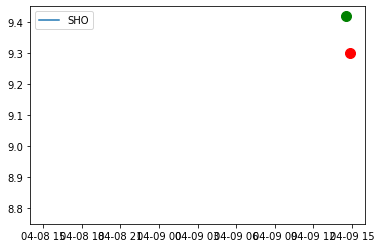

PSTI analysis for run 228 with profit -19.95


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-414.96,-414.96,buy,2020-04-09 15:01:13.290195,7.28,"[3.24, 3.47, 3.9, 4.16, 4.44, 4.62, 4.71, 4.87, 5.0, 5.2, 6.5]",[7.44],57,"{'rsi': 70.43223292011201, 'macd': [0.15876646616232293, 0.17934376762221937, 0.18624229420621496, 0.19988709658163906, 0.2067120887950722], 'sell_macd': [0.09881700090372458, 0.11175178448184298, 0.11570419006892418, 0.12402938675926123, 0.12787201552109106], 'slow macd': [0.15129185427150116, 0.15699291004548233, 0.16054755126729336, 0.16563873049412958, 0.16973958954210033], 'macd_signal': [0.10783326428713072, 0.12213536495414845, 0.13495675080456176, 0.1479428199599772, 0.1596966737269962], 'sell_macd_signal': [0.0663465452620642, 0.07542759310601996, 0.0834829124986008, 0.0915922073507329, 0.09884816898480453]}",10.34,6.26
1,-19.95,395.01,sell,2020-04-09 15:21:22.887202,6.93,None,None,57,"{'rsi': 45.46237013656456, 'reasons': 'below cost & macd negative', 'movement': -0.04504120879120886, 'sell_macd': [0.027788536427004296, 0.01721779170002069, 0.00927672059198148, 0.006345019461145185, -0.00032831933510557576], 'sell_macd_signal': [0.04952695190447296, 0.04306511986358251, 0.0363074400092623, 0.03031495589963888, 0.02418630085268999]}",10.34,6.26


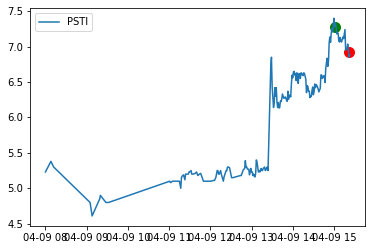

LBTYA analysis for run 228 with profit -16.92


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3575.76,-3575.76,buy,2020-04-09 14:18:55.636119,19.02,"[16.61, 18.19, 18.93]",[19.11],188,"{'rsi': 61.67195186860859, 'macd': [0.007294469149723426, 0.004623733750332093, 0.008062630702369233, 0.015451366141121525, 0.02545164187072757], 'sell_macd': [-0.0024997094500314176, -0.0038080333318717408, -0.0011416878718506496, 0.004067694147281031, 0.010931268523911797], 'slow macd': [0.08304134244155748, 0.08092098508594958, 0.07996031886620258, 0.07990820601250093, 0.08061210665207952], 'macd_signal': [0.0347437335949581, 0.0287197336260329, 0.024588313041300165, 0.022760923661264438, 0.023299067303157065], 'sell_macd_signal': [0.014220089718873001, 0.010614465108724052, 0.008263234512609113, 0.007424126439543497, 0.008125554856417156]}",19.97,18.71
1,-16.92,3558.84,sell,2020-04-09 14:42:25.091330,18.93,None,None,188,"{'rsi': 44.99280795308807, 'reasons': 'below cost & macd negative', 'movement': -0.006044678055190457, 'sell_macd': [0.00857033029269516, 0.008968799788270587, 0.005526453943414111, 0.003291814922185665, -5.0654638801717056e-05], 'sell_macd_signal': [0.01354500556113164, 0.01262976440655943, 0.011209102313930366, 0.009625644835581426, 0.007690384940704798]}",19.97,18.71


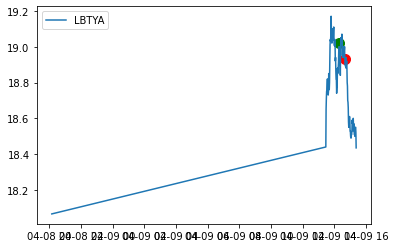

ENBL analysis for run 228 with profit -63.9


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1789.2,-1789.2,buy,2020-04-09 14:43:05.151005,2.8,"[2.22, 2.52, 2.77]",[2.81],639,"{'rsi': 68.41914945279281, 'macd': [0.01899499006071448, 0.023412264602919564, 0.02760343679863153, 0.029336082401555164, 0.03201053599471093], 'sell_macd': [0.011471581519407525, 0.01432573070165244, 0.017013045250133363, 0.018080913141805155, 0.01975352561399335], 'slow macd': [0.02313972987068924, 0.024101372666266663, 0.025147488052895017, 0.025821826938309478, 0.026732009452337557], 'macd_signal': [0.01164253791083382, 0.013996483249250968, 0.01671787395912708, 0.019241515647612697, 0.021795319717032344], 'sell_macd_signal': [0.006553850005511397, 0.008108226144739605, 0.009889189965818357, 0.011527534601015717, 0.013172732803611243]}",3.08,2.71
1,-63.9,1725.3,sell,2020-04-09 15:03:25.032702,2.7,None,None,639,"{'rsi': 39.023582764778816, 'reasons': 'stopped', 'movement': -0.033075248867163884, 'sell_macd': [0.008034600574055695, 0.006897346947315253, 0.004882638316773047, 0.0032493246005484977, 0.00037597203465189466], 'sell_macd_signal': [0.010475303878193041, 0.009759712492017483, 0.008784297656968596, 0.007677303045684576, 0.00621703684347804]}",3.08,2.71


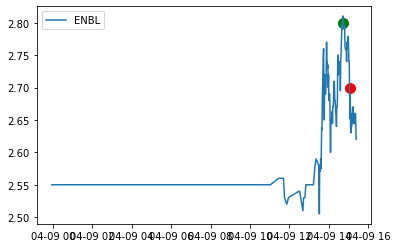

SLB analysis for run 228 with profit -26.25


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1382.25,-1382.25,buy,2020-04-09 14:36:01.018746,18.43,"[13.09, 14.16, 15.38, 16.77]",[],75,"{'rsi': 65.55878835667008, 'macd': [0.034663583023863964, 0.04687909375982713, 0.07107211107421563, 0.0995871860518811, 0.11236125122182372], 'sell_macd': [0.020544737074590813, 0.028531254727347743, 0.044254109330438496, 0.06268420240647998, 0.07074032425266097], 'slow macd': [0.07423921048246385, 0.07591819602562566, 0.08038028037217515, 0.08643615200748656, 0.09017898128570323], 'macd_signal': [0.00932209012792452, 0.016833490854305043, 0.027681214898287163, 0.042062409129005954, 0.056122177547569506], 'sell_macd_signal': [0.0031167885951528954, 0.008199681821591864, 0.015410567323361192, 0.024865294339984953, 0.03404030032252016]}",20.79,17.65
1,-26.25,1356.00,sell,2020-04-09 14:52:17.939469,18.08,None,None,75,"{'rsi': 37.51271925136204, 'reasons': 'below cost & macd negative', 'movement': -0.01921960692838904, 'sell_macd': [0.039171246040876184, 0.032998773925257296, 0.024643616771200527, 0.011059810978803597, -0.0007075677033085981], 'sell_macd_signal': [0.05271752904784246, 0.04877377802332543, 0.04394774577290045, 0.03737015881408108, 0.029754613510603146]}",20.79,17.65


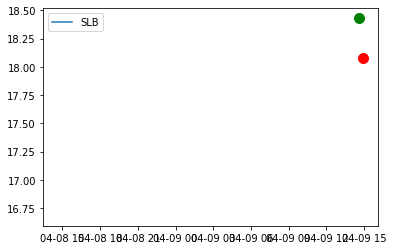

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


UE analysis for run 228 with profit -35.46


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1940.45,-1940.45,buy,2020-04-09 14:43:27.868901,9.85,"[7.83, 8.47, 9.15, 9.75]",[9.89],197,"{'rsi': 58.76636258418927, 'macd': [-0.013949902611475551, -0.006771903341972418, 0.0037153827334730494, 0.015080460054878841, 0.022217424223445192], 'sell_macd': [-0.012408654284305598, -0.0073937579934142406, -0.0002731406499485445, 0.007356861704050033, 0.012167813386334103], 'slow macd': [0.06319688502056131, 0.06258851415152655, 0.06288830806346013, 0.06370329109389061, 0.0640313449877894], 'macd_signal': [-0.008275591202656684, -0.007974853630519831, -0.005636806357721255, -0.0014933530752012352, 0.003248802384528051], 'sell_macd_signal': [-0.010308608522920553, -0.00972563841701929, -0.00783513886360514, -0.004796738750074105, -0.0014038283227924635]}",10.76,9.56
1,-35.46,1904.99,sell,2020-04-09 14:55:28.460200,9.67,None,None,197,"{'rsi': 42.08084608490326, 'reasons': 'below cost & macd negative', 'movement': -0.01724137931034482, 'sell_macd': [0.0080124379197688, 0.006350099357364414, 0.004452821265136464, 0.002542567930087003, -0.001721818667745012], 'sell_macd_signal': [0.007731440708469093, 0.007455172438248158, 0.006854702203625819, 0.005992275348918056, 0.004449456545585442]}",10.76,9.56


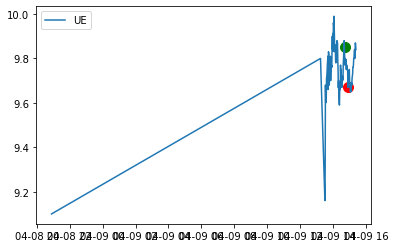

MOS analysis for run 228 with profit -6.04


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1973.57,-1973.57,buy,2020-04-09 14:35:18.240913,13.07,"[9.96, 10.52, 11.05, 11.8, 12.9]",[13.12],151,"{'rsi': 67.2290482663462, 'macd': [0.001513863548881389, 0.011621633488033467, 0.01980724659149402, 0.02878677541509944, 0.038285987166755575], 'sell_macd': [-0.004423080631861254, 0.002583112930835796, 0.008268677876694497, 0.01440978461532616, 0.02082610435172505], 'slow macd': [0.1100810928833873, 0.1094058577379009, 0.10868960843733433, 0.10841657841960028, 0.10855176099277841], 'macd_signal': [0.002647132758216571, 0.00444203290417995, 0.0075150756416427645, 0.0117694155963341, 0.017072729910418395], 'sell_macd_signal': [-0.005802928543272303, -0.004125720248450683, -0.0016468406234216469, 0.001564484424327915, 0.005416808409807342]}",14.24,12.68
1,-6.04,1967.53,sell,2020-04-09 15:01:05.850670,13.03,None,None,151,"{'rsi': 38.7365964574183, 'reasons': 'below cost & macd negative', 'movement': -0.003825554705432342, 'sell_macd': [0.01652247462254408, 0.013627235573290264, 0.009635786501490884, 0.003543283503967487, -0.001250138098050968], 'sell_macd_signal': [0.026671463906532, 0.024062618239883656, 0.021177251892205103, 0.01765045821455758, 0.013870338952035871]}",14.24,12.68


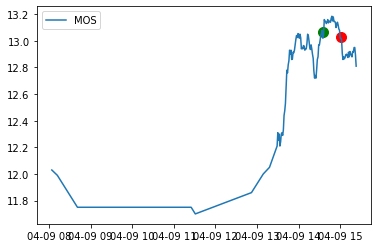

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


RLGY analysis for run 228 with profit -11.88


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1290.96,-1290.96,buy,2020-04-09 14:47:11.147058,3.26,"[2.32, 2.42, 2.64, 2.74, 2.8, 2.86, 3.13]",[3.28],396,"{'rsi': 61.18260447686071, 'macd': [0.003920415194529792, 0.00419262930111719, 0.0055547044068351425, 0.007356276590439137, 0.00948165335434048], 'sell_macd': [0.002580430012897761, 0.0027591841572585096, 0.0036418603196528565, 0.004801843558925878, 0.006162845517334592], 'slow macd': [0.015194774255409271, 0.014950462263501496, 0.014941680279321634, 0.015069639468960006, 0.01532320025963596], 'macd_signal': [-0.0034324819506655695, -0.0019074597003090174, -0.0004150268788801852, 0.0011392338149836794, 0.0028077177228550397], 'sell_macd_signal': [-0.0024889755852144932, -0.0014393436367198926, -0.0004231028454453427, 0.0006218864354289016, 0.0017300782518100397]}",3.71,3.12
1,-11.88,1279.08,sell,2020-04-09 15:00:07.525572,3.23,None,None,396,"{'rsi': 46.96412599457007, 'reasons': 'below cost & macd negative', 'movement': -0.01531393568147022, 'sell_macd': [0.0017423568202810102, 0.001562282737936016, 0.0003627148460059182, 0.00046223707507353495, -0.00024543699416046394], 'sell_macd_signal': [0.0025557466914963157, 0.002357053900784256, 0.0019581860898285884, 0.0016589962868775777, 0.0012781096306699693]}",3.71,3.12


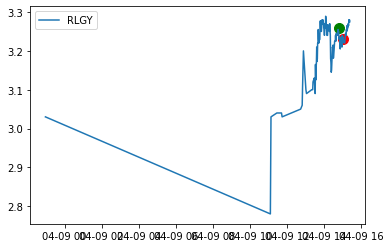

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


TRIP analysis for run 228 with profit -29.37


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1635.82,-1635.82,buy,2020-04-09 13:54:20.109444,18.38,"[15.9, 17.18, 18.02]",[18.41],89,"{'rsi': 62.61784273591016, 'macd': [0.16639378916751824, 0.17075261439239142, 0.1714240288632496, 0.17637828203713113, 0.18383385609601532], 'sell_macd': [0.1021830446465728, 0.10455566947067751, 0.10452712167815292, 0.10730322571412998, 0.11170923891470963], 'slow macd': [0.08494086342615859, 0.0897121205186977, 0.093798411637394, 0.09868740092870709, 0.10414714293414207], 'macd_signal': [0.13287405692636114, 0.1404497684195672, 0.14664462050830368, 0.15259135281406916, 0.1588398534704584], 'sell_macd_signal': [0.08195425933152486, 0.0864745413593554, 0.0900850574231149, 0.09352869108131792, 0.09716480064799626]}",20.4,17.72
1,-29.37,1606.45,sell,2020-04-09 14:15:42.643749,18.05,None,None,89,"{'rsi': 43.66991190260349, 'reasons': 'below cost & macd negative', 'movement': -0.014681892332789536, 'sell_macd': [0.025609240385065846, 0.01862696343383874, 0.01354172212855076, 0.005777355888994862, -0.00035821982869777], 'sell_macd_signal': [0.053918006401250565, 0.0468597978077682, 0.040196182671924714, 0.033312417315338745, 0.026578289886531443]}",20.4,17.72


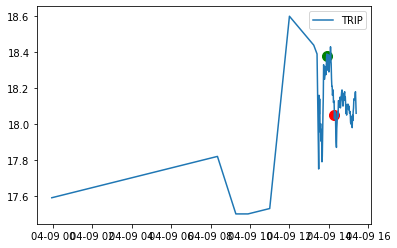

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


GLOG analysis for run 228 with profit -31.2


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1170.0,-1170.0,buy,2020-04-09 14:45:41.173257,3.75,"[3.1, 3.42, 3.54, 3.6]",[],312,"{'rsi': 60.325299170404776, 'macd': [0.0124626266477037, 0.019353262934727056, 0.0261268011888367, 0.027945079864406086, 0.029848915523448483], 'sell_macd': [0.005248703380142494, 0.009868284140341022, 0.014378758964647353, 0.01562875546456599, 0.01691928838054757], 'slow macd': [0.03979804251675567, 0.040689731076123614, 0.041764907585840394, 0.0420475631310282, 0.04240030209822221], 'macd_signal': [0.01717832903494402, 0.017613315814900627, 0.01931601288968784, 0.02104182628463149, 0.02280324413239489], 'sell_macd_signal': [0.007835961812734325, 0.008242426278255664, 0.009469692815534001, 0.010701505345340399, 0.011945061952381833]}",4.32,3.56
1,-31.2,1138.8,sell,2020-04-09 15:01:19.758241,3.65,None,None,312,"{'rsi': 43.59115503438106, 'reasons': 'below cost & macd negative', 'movement': -0.023999999999999962, 'sell_macd': [0.006536708542960401, 0.005398961653932943, 0.003403328212431944, 0.0018040900994127362, -0.0005044602496857564], 'sell_macd_signal': [0.009990204200484092, 0.009071955691173863, 0.007938230195425479, 0.00671140217622293, 0.005268229691041193]}",4.32,3.56


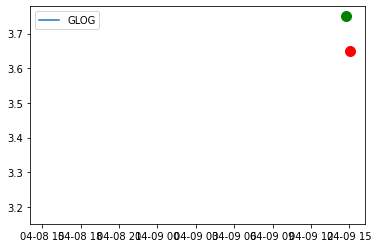

OESX analysis for run 228 with profit -71.16


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4696.56,-4696.56,buy,2020-04-09 14:05:43.208583,3.96,"[3.21, 3.62]",[3.97],1186,"{'rsi': 62.55119251866379, 'macd': [0.037572019679393165, 0.036161812614840194, 0.03530695736352518, 0.03679552424795318, 0.037542458140334745], 'sell_macd': [0.0243584583147074, 0.023255178468503335, 0.02252463341342814, 0.023330382287221507, 0.023655246574758593], 'slow macd': [0.005839281463824619, 0.006724117205362479, 0.007660187006425012, 0.0090225444091514, 0.010261526498730689], 'macd_signal': [0.02419149719251232, 0.026585560276977897, 0.028329839694287352, 0.03002297660502052, 0.031526872912083365], 'sell_macd_signal': [0.016166927281909462, 0.017584577519228237, 0.01857258869806822, 0.019524147415898876, 0.02035036724767082]}",4.12,3.92
1,-71.16,4625.40,sell,2020-04-09 14:20:48.866264,3.90,None,None,1186,"{'rsi': 47.77139840596579, 'reasons': 'stopped', 'movement': -0.015113350125944598, 'sell_macd': [0.015799882246943397, 0.01534402018606329, 0.014270049486857062, 0.014806305442191636, 0.011395513908138089], 'sell_macd_signal': [0.017803925371550924, 0.017311944334453398, 0.01670356536493413, 0.016324113380385634, 0.015338393485936125]}",4.12,3.92


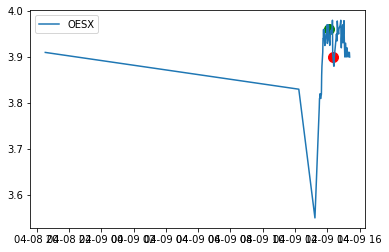

HAL analysis for run 228 with profit -22.44


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-986.34,-986.34,buy,2020-04-09 14:35:18.111538,9.67,"[6.82, 6.92, 7.09, 7.89, 8.82, 9.17, 9.48]",[9.74],102,"{'rsi': 74.33027698025877, 'macd': [0.008879921555463355, 0.015836837992967645, 0.02547844673468269, 0.04071926900543055, 0.0621675568927067], 'sell_macd': [0.004855341141189129, 0.00945391509690019, 0.015761194606586315, 0.025666072216646185, 0.03954433954634595], 'slow macd': [0.05347439311735691, 0.05370946964343837, 0.05471629619599305, 0.05715445801632235, 0.06130543463228122], 'macd_signal': [-0.004305614750984861, -0.00027712420219436033, 0.004873989985181051, 0.01204304578923095, 0.022067948009926102], 'sell_macd_signal': [-0.004535505968536467, -0.0017376217554491355, 0.0017621415169579548, 0.006542927656895602, 0.013143210034785672]}",11.42,9.1
1,-22.44,963.90,sell,2020-04-09 15:02:06.072013,9.45,None,None,102,"{'rsi': 40.33898893581881, 'reasons': 'below cost & macd negative', 'movement': -0.022210743801652878, 'sell_macd': [0.023332439360526536, 0.019504716881455053, 0.012372664081119922, 0.004368822105780268, -0.001716883616639464], 'sell_macd_signal': [0.028562997699775695, 0.026751341536111566, 0.023875606045113237, 0.019974249257246644, 0.01563602268246942]}",11.42,9.1


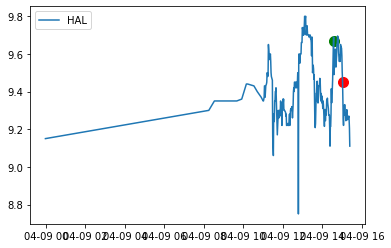

NEWT analysis for run 228 with profit -1108.1


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1108.1,-1108.1,buy,2020-04-09 14:41:33.744991,15.83,"[9.7, 10.04, 10.35, 11.11, 12.1, 13.86, 15.22]",[16.15],70,"{'rsi': 73.14966074909319, 'macd': [0.05872690445565354, 0.06407215850753545, 0.08747288850821278, 0.10879855573372055, 0.13463720036072857], 'sell_macd': [0.030357411734097894, 0.03415499692166257, 0.049657595809094346, 0.0636900417498314, 0.0805505185640456], 'slow macd': [0.1568351608281784, 0.15608574071186965, 0.15914501354254718, 0.1625047923227232, 0.1674151608968497], 'macd_signal': [0.0443207773866927, 0.048271053610861245, 0.05611142059033155, 0.06664884761900935, 0.0802465181673532], 'sell_macd_signal': [0.01881628384856005, 0.021884026463180557, 0.027438740332363314, 0.03468900061585693, 0.04386130420549467]}",18.36,15.0


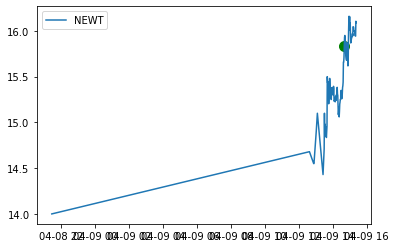

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


ECC analysis for run 228 with profit -1414.59


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1414.59,-1414.59,buy,2020-04-09 14:51:26.017404,7.73,"[5.03, 5.38, 6.16, 6.56, 7.53, 7.7]",[7.76],183,"{'rsi': 64.75391904314571, 'macd': [0.00249489968864669, 0.01090817160266866, 0.01976861915237027, 0.026596962740855545, 0.037116069965556164], 'sell_macd': [-0.0036020867489847674, 0.00229181506721865, 0.00841314355949141, 0.013146475585164907, 0.02022768916899942], 'slow macd': [0.10320685727867929, 0.10241858061907827, 0.10200934474694012, 0.10149207600612531, 0.1019510109614874], 'macd_signal': [0.0009030640750117495, 0.0029040855805431316, 0.00627699229490856, 0.010340986384097958, 0.0156960031003896], 'sell_macd_signal': [-0.006843968234643517, -0.005016811574271083, -0.0023308205475185847, 0.0007646386790181141, 0.004657248777014376]}",8.69,7.41


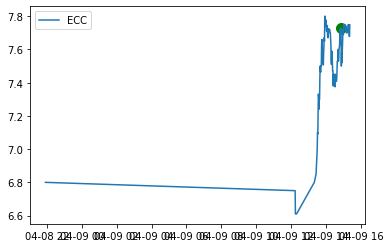

GBDC analysis for run 228 with profit -1369.5


<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1369.5,-1369.5,buy,2020-04-09 14:39:10.400904,12.45,"[9.41, 9.75, 10.11, 11.04, 12.38]",[12.48],110,"{'rsi': 64.92338487368481, 'macd': [-0.012511464629071156, -0.0025863536258867725, 0.005131455321063072, 0.022375534065012914, 0.03563086032804996], 'sell_macd': [-0.015692582910604713, -0.008577379939776364, -0.002978814249004813, 0.008752260500285658, 0.017779691986742563], 'slow macd': [0.13509685443824004, 0.1333429190879425, 0.13149838613417053, 0.13184774084381878, 0.13195828631504192], 'macd_signal': [-0.0015794785763219733, -0.0017808535862349332, -0.0003983918047753322, 0.004156393369182317, 0.010451286760955848], 'sell_macd_signal': [-0.011549083277123309, -0.01095474260965392, -0.009359556937524098, -0.005737193449962147, -0.0010338163626212055]}",14.07,11.91


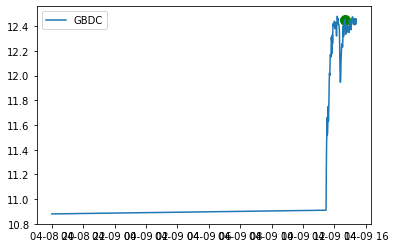

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


PHR analysis for run 228 with profit -1180.8


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1180.8,-1180.8,buy,2020-04-09 14:47:57.700912,19.68,"[18.45, 19.58]",[19.76],60,"{'rsi': 65.9433694880431, 'macd': [0.22697994570612323, 0.26042743328905615, 0.27249680466270476, 0.2772520465689787, 0.28818846633521744], 'sell_macd': [0.13392113273252448, 0.15538278447018072, 0.16281546394796464, 0.1654537146586037, 0.1721139916453538], 'slow macd': [0.13244012796301874, 0.14440803315996575, 0.152948823933869, 0.1602421323205192, 0.16877509276370262], 'macd_signal': [0.21269826489735041, 0.22224409857569155, 0.2322946397930942, 0.2412861211482711, 0.2506665901856604], 'sell_macd_signal': [0.12642140383651973, 0.13221367996325192, 0.13833403676019446, 0.1437579723398763, 0.1494291762009718]}",22.63,18.7


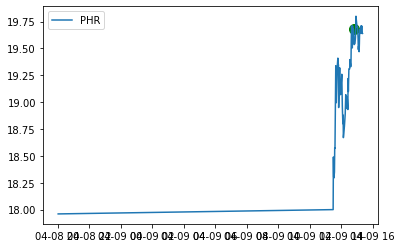

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


BMA analysis for run 228 with profit -2823.66


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2823.66,-2823.66,buy,2020-04-09 15:00:17.762982,17.01,[16.45],"[17.27, 18.34]",166,"{'rsi': 61.880617814441386, 'macd': [0.05363243718791466, 0.056116817032609845, 0.055828318996031356, 0.05735923000445453, 0.06348904085146145], 'sell_macd': [0.030251139285006445, 0.031959453599867516, 0.03183658873352613, 0.03288582924373529, 0.03691269419657672], 'slow macd': [0.08944003809659051, 0.08963041514807557, 0.08934234475018954, 0.08941422825096978, 0.0904569099871928], 'macd_signal': [0.03895486322897986, 0.04238725398970586, 0.04507546699097096, 0.04753221959366767, 0.050723583845226426], 'sell_macd_signal': [0.019677601693794268, 0.022133972075008918, 0.02407449540671236, 0.025836762174116946, 0.0280519485786089]}",18.11,16.71


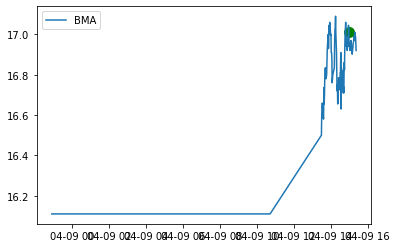

<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:21: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


ALDX analysis for run 228 with profit -1195.56


<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in greater_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
<ipython-input-61-7e70cd189475>:43: RuntimeWarning: invalid value encountered in less_equal
  high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1195.56,-1195.56,buy,2020-04-09 13:49:40.313044,2.46,"[2.18, 2.44]",[2.46],486,"{'rsi': 71.45843326078635, 'macd': [0.030999165093168912, 0.03452270303305216, 0.03768760936164384, 0.04292863159217397, 0.04734335121333366], 'sell_macd': [0.02007265832119698, 0.022225981836914155, 0.024134727669460787, 0.02738654614067304, 0.030084241752777796], 'slow macd': [0.005369316377844324, 0.007026227522020534, 0.008699337331161683, 0.010864482601656622, 0.012999045311373969], 'macd_signal': [0.017273359229096764, 0.020723227989887842, 0.02411610426423904, 0.027878609729826025, 0.03177155802652755], 'sell_macd_signal': [0.011432500120339148, 0.01359119646365415, 0.01569990270481548, 0.018037231391986992, 0.02044663346414515]}",2.83,2.34


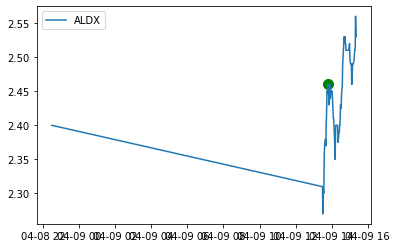

In [62]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            continue
        start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d").date()
        minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
        plt.plot(minute_history[symbol]["close"][minute_history_index:], label=symbol)

        delta = 0
        profit = 0
        
        operations = []
        deltas = []
        profits = []
        times = []
        prices = []
        qtys = []
        indicators = []
        target_price = []
        stop_price = []
        resistances = []
        supports = []
        for trade in trade_details[run_id][symbol]:
            resistance = None
            support = None
            if trade[0] == 'buy':
                resistance = find_resistance(trade[2], minute_history[symbol], trade[1])
                support = find_support(trade[2], minute_history[symbol], trade[1])
                
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' else -1)
            profit += delta
            plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' else 'r', s=100)
            deltas.append(round(delta, 2))
            profits.append(round(profit, 2))
            operations.append(trade[0])
            times.append(pd.to_datetime(trade[1]))
            prices.append(trade[2])
            qtys.append(trade[3])
            indicators.append(trade[4])
            target_price.append(trade[6])
            stop_price.append(trade[5])    
            resistances.append(resistance)
            supports.append(support)
        d = {
            'profit': profits,
            'trade': deltas,
            'operation': operations,
            'at': times,
            'price': prices,
            'support': supports,
            'resistance': resistances,
            'qty': qtys,
            'indicators': indicators,
            'target price': target_price,
            'stop price': stop_price
        }   
        print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
        display(HTML(pd.DataFrame(data=d).to_html()))
        plt.legend()
        plt.show()

In [ ]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            print(symobl)
            continue
           
        print (f'{symbol} analysis for run {run_id}')
        plt.plot(minute_history[symbol]['close'], label=symbol)

        for trade in trade_details[run_id][symbol]:
            print(f'operation {trade[0]} price {trade[2]} qty {trade[3]}')

            plt.scatter(parser.isoparse(trade[1]), trade[2], c='g' if trade[0] == 'buy' else 'r', s=100)
    
        plt.legend()
        plt.show()

        min_time = trade_details[run_id][symbol][0][0]
        max_time = trade_details[run_id][symbol][-1][2]
        delta = 0 
        accumulative_delta = []
        
  #      if min_time not in minute_history[symbol]['close'] or max_time not in minute_history[symbol]['close']:
  #          continue
        plt.plot(minute_history[symbol]['close'][min_time:max_time], label=symbol)
                

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
 #           t = parser.isoparse(trade[0])
 #           t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
 #           if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
 #               continue 

                
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            trade_delta = trade[3] - trade[1]
            delta += trade_delta 
            accumulative_delta.append(delta)
            
        plt.legend()
        plt.show()

        print(f'Delta = {delta}')
        plt.plot(range(len(accumulative_delta)), accumulative_delta)
        plt.show()

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
#            t = parser.isoparse(trade[0])
#            t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
#            if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
#                continue

                
            plt.plot(minute_history[symbol]['close'][trade[0]:trade[2]])
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            plt.show()
            print(f"buy time:{trade[0]} sell time:{trade[2]}")
            print(trade[4])
            print(trade[5])

